In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import load_breast_cancer
import shap 

## code extracted from https://www.kaggle.com/code/graymant/breast-cancer-diagnosis-with-pytorch
## SV code extracted from https://github.com/mburaksayici/ExplainableAI-Pure-Numpy/blob/main/KernelSHAP-Pure-Numpy.ipynb

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = load_breast_cancer()
print(data.target[[10,50,85]])
print(list(data.target_names))

[0 1 0]
['malignant', 'benign']


In [3]:
print(np.shape(data.data))
print(np.shape(data.target))
print(data.target[0])

(569, 30)
(569,)
0


In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
from collections import Counter

In [5]:
#x = data.drop(["id", "diagnosis", "Unnamed: 32"], axis=1)
#diag = { "M": 1, "B": 0}
#y = data["diagnosis"].replace(diag)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train, x_test, y_train, y_test = train_test_split(data.data[:,:], data.target, test_size=0.2, random_state=85)



In [6]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import operator

from IPython.core.display import display

import torch
from torch.autograd import Variable
import torch.utils.data as data_utils
import torch.nn.init as init

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [7]:
scaler = StandardScaler()
transformed = scaler.fit_transform(x_train)

train = data_utils.TensorDataset(torch.from_numpy(transformed).float(),
                                 torch.from_numpy(y_train).float())
dataloader = data_utils.DataLoader(train, batch_size=128, shuffle=False)

In [8]:
def create_model(layer_dims):
    model = torch.nn.Sequential()
    for idx, dim in enumerate(layer_dims):
        if (idx < len(layer_dims) - 1):
            module = torch.nn.Linear(dim, layer_dims[idx + 1])
            init.xavier_normal(module.weight)
            model.add_module("linear" + str(idx), module)
        else:
            model.add_module("sig" + str(idx), torch.nn.Sigmoid())
        if (idx < len(layer_dims) - 2):
            model.add_module("relu" + str(idx), torch.nn.ReLU())

    return model

In [9]:

scaler = StandardScaler()
transformed = scaler.fit_transform(x_test)

test_set = torch.from_numpy(transformed).float()
test_valid = torch.from_numpy(y_test).float()



In [10]:
## Create model and hyper parameters
dim_in = x_train.shape[1]
dim_out = 1

layer_dims = [dim_in, 20, 10, dim_out]

model = create_model(layer_dims)

loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 0.0007
n_epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Now run model
history = { "loss": [], "accuracy": [], "loss_val": [], "accuracy_val": [] }
for epoch in range(n_epochs):
    loss = None

    for idx, (minibatch, target) in enumerate(dataloader):
        y_pred = model(Variable(minibatch))

        loss = loss_fn(y_pred, Variable(target.float()).unsqueeze(1))

        prediction = [1 if x > 0.5 else 0 for x in y_pred.data.numpy()]
        correct = (prediction == target.numpy()).sum()
        
        # This can be uncommented for a per mini batch feedback
        #history["loss"].append(loss.data[0])
        #history["accuracy"].append(100 * correct / len(prediction))
        
        y_val_pred = model(Variable(test_set))
        loss_val = loss_fn(y_val_pred, Variable(test_valid.float()).unsqueeze(1))
        prediction_val = [1 if x > 0.5 else 0 for x in y_val_pred.data.numpy()]
        correct_val = (prediction_val == test_valid.numpy()).sum()
        
        # This can be uncommented for a per mini batch feedback
        #history["loss_val"].append(loss_val.data[0])
        #history["accuracy_val"].append(100 * correct_val / len(prediction_val))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    history["loss"].append(loss.detach().cpu().numpy())
    history["accuracy"].append(100 * correct / len(prediction))
    history["loss_val"].append(loss_val.detach().cpu().numpy())
    history["accuracy_val"].append(100 * correct_val / len(prediction_val))
    print("Loss, accuracy, val loss, val acc at epoch", epoch + 1,history["loss"][-1], 
          history["accuracy"][-1], history["loss_val"][-1], history["accuracy_val"][-1] )


index, value = max(enumerate(history["accuracy_val"]), key=operator.itemgetter(1))

print("Best accuracy was {} at iteration {}".format(value, index))


nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
size_average and reduce args will be deprecated, please use reduction='sum' instead.


Loss, accuracy, val loss, val acc at epoch 1 22.75661 32.394366197183096 38.552937 28.07017543859649
Loss, accuracy, val loss, val acc at epoch 2 21.690565 38.028169014084504 36.5381 30.70175438596491
Loss, accuracy, val loss, val acc at epoch 3 20.734934 39.436619718309856 34.583473 35.08771929824562
Loss, accuracy, val loss, val acc at epoch 4 19.832268 42.25352112676056 32.741997 39.473684210526315
Loss, accuracy, val loss, val acc at epoch 5 18.964157 46.478873239436616 31.004742 46.49122807017544
Loss, accuracy, val loss, val acc at epoch 6 18.209837 47.88732394366197 29.350992 49.12280701754386
Loss, accuracy, val loss, val acc at epoch 7 17.469456 52.11267605633803 27.79766 50.87719298245614
Loss, accuracy, val loss, val acc at epoch 8 16.762608 63.38028169014085 26.39845 61.40350877192982
Loss, accuracy, val loss, val acc at epoch 9 16.091696 67.6056338028169 25.04112 64.03508771929825
Loss, accuracy, val loss, val acc at epoch 10 15.36839 70.4225352112676 23.797394 66.66666666

Loss, accuracy, val loss, val acc at epoch 87 1.4791229 97.1830985915493 3.09046 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 88 1.4518327 97.1830985915493 3.0725212 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 89 1.4252975 97.1830985915493 3.0553942 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 90 1.3995435 97.1830985915493 3.0391269 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 91 1.3741521 97.1830985915493 3.0243952 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 92 1.3494083 97.1830985915493 3.0102537 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 93 1.3252481 97.1830985915493 2.997083 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 94 1.3018318 97.1830985915493 2.983748 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 95 1.2800536 97.1830985915493 2.9708438 96.49122807017544
Loss, accuracy, val loss, val acc at epoch 96 1.2610193 97.1830985915493 2.9593241 96.491228070

Loss, accuracy, val loss, val acc at epoch 174 0.30019826 100.0 2.7724597 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 175 0.29616475 100.0 2.7737238 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 176 0.29192504 100.0 2.7741616 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 177 0.2867434 100.0 2.7739747 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 178 0.28219977 100.0 2.7748544 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 179 0.27844995 100.0 2.7768314 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 180 0.27466115 100.0 2.7782938 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 181 0.27019373 100.0 2.7793632 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 182 0.2662334 100.0 2.7811341 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 183 0.26234224 100.0 2.7822652 97.36842105263158
Loss, accuracy, val loss, val acc at epoch 184 0.25855786 100.0 2.7838938 97.36842

Loss, accuracy, val loss, val acc at epoch 267 0.08315003 100.0 2.6895566 98.24561403508773
Loss, accuracy, val loss, val acc at epoch 268 0.08184006 100.0 2.6894178 98.24561403508773
Loss, accuracy, val loss, val acc at epoch 269 0.08072437 100.0 2.6893032 98.24561403508773
Loss, accuracy, val loss, val acc at epoch 270 0.07978827 100.0 2.6880622 98.24561403508773
Loss, accuracy, val loss, val acc at epoch 271 0.07885582 100.0 2.686716 98.24561403508773
Loss, accuracy, val loss, val acc at epoch 272 0.07796633 100.0 2.6860561 98.24561403508773
Loss, accuracy, val loss, val acc at epoch 273 0.07667967 100.0 2.6859782 98.24561403508773
Loss, accuracy, val loss, val acc at epoch 274 0.075443365 100.0 2.6855397 98.24561403508773
Loss, accuracy, val loss, val acc at epoch 275 0.07435809 100.0 2.6840768 98.24561403508773
Loss, accuracy, val loss, val acc at epoch 276 0.07349785 100.0 2.6816964 98.24561403508773
Loss, accuracy, val loss, val acc at epoch 277 0.07275831 100.0 2.6793318 98.245

In [11]:
print(target.shape)
print(loss.shape)
print(y_pred.shape)

torch.Size([71])
torch.Size([])
torch.Size([71, 1])


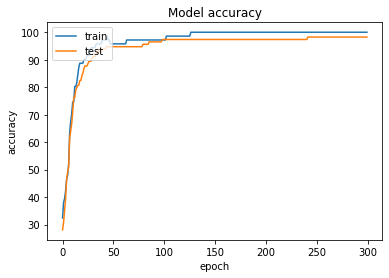

In [12]:
plt.plot(history['accuracy'])
plt.plot(history['accuracy_val'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
instance_to_explain = test_set[0,:] #.detach().cpu().numpy() #x_test[0]
print(instance_to_explain)
     
y_val_pred = model(Variable(instance_to_explain))
print(f"model score for the prediction to be explained: f{instance_to_explain}={y_val_pred[0]:.3f}")

x = scaler.fit_transform(x_train)
x_min, x_max = x[:,0].min() -1, x[:,0].max() + 1 
y_min, y_max = x[:,1].min() -1, x[:,1].max() + 1 
xx, yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                    np.arange(y_min,y_max,0.1))

Z = model(Variable(torch.from_numpy(np.c_[xx.ravel(),yy.ravel()]).float()))
Z = Z.reshape(xx.shape)
Z = Z.detach().cpu().numpy()

tensor([-0.9102, -0.4081, -0.8766, -0.8008,  0.0956, -0.1187, -0.4710, -0.5666,
        -0.7301,  0.3863, -0.8411,  0.6534, -0.7727, -0.5698,  0.5024,  0.3104,
         0.3529,  0.1498, -0.8948, -0.0774, -0.9539,  0.1766, -0.9011, -0.7920,
         0.6129,  0.0140, -0.2957, -0.2589, -0.9297,  0.0606])
model score for the prediction to be explained: ftensor([-0.9102, -0.4081, -0.8766, -0.8008,  0.0956, -0.1187, -0.4710, -0.5666,
        -0.7301,  0.3863, -0.8411,  0.6534, -0.7727, -0.5698,  0.5024,  0.3104,
         0.3529,  0.1498, -0.8948, -0.0774, -0.9539,  0.1766, -0.9011, -0.7920,
         0.6129,  0.0140, -0.2957, -0.2589, -0.9297,  0.0606])=0.999


RuntimeError: mat1 and mat2 shapes cannot be multiplied (7128x2 and 30x20)

In [ ]:
f, axarr = plt.subplots(1,2)

for ax in axarr: 
    ax.contourf(xx,yy,Z,alpha=0.4)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.scatter([instance_to_explain[0]],[instance_to_explain[1]],c="black",s=400)
    
axarr[0].scatter(x[:,0],x[:,1],c=y_train,s=20,alpha=0.5,edgecolor='r')



In [ ]:
n_samples = 100
x1_present = np.column_stack((np.full(n_samples,instance_to_explain[0].detach().cpu().numpy())
                              ,np.random.randn(n_samples)))
x2_present = np.column_stack((np.random.randn(n_samples),
                             np.full(n_samples,instance_to_explain[1].detach().cpu().numpy())))

f_x1_present = model(Variable(torch.from_numpy(x1_present).float()))
f_x2_present = model(Variable(torch.from_numpy(x2_present).float()))

f_x1_avg = np.mean(f_x1_present.detach().cpu().numpy())
f_x2_avg = np.mean(f_x2_present.detach().cpu().numpy())

print("avg x1: ",f_x1_avg)
print("avg x2: ",f_x2_avg)

#x2_present 

In [ ]:
# solve for phi_1
from sklearn.linear_model import LinearRegression
non_zero_z = np.array([1., 1.]) # number of non-zero elements 
sample_weights = np.array([0.5,0.5])

transformed = scaler.fit_transform(x_train)

mean_array = torch.mean(torch.from_numpy(transformed).float(),0)
print(mean_array)

phi0 = model(Variable(mean_array))

X_shap = np.array([[1], [-1]])
y_shap = np.array([[f_x1_avg-phi0.detach().cpu().numpy()],[f_x2_avg-y_val_pred.detach().cpu().numpy()]])

y_shap = np.reshape(y_shap,(2,1))
solver = LinearRegression(fit_intercept=False)

solver.fit(X_shap,y_shap,sample_weight=sample_weights)

phi1 = solver.coef_[0][0]
phi2 = y_val_pred - phi0 - phi1 

print(phi1)
print(phi2)
print(phi0)
print(y_val_pred)


In [ ]:
# solve for phi_2
from sklearn.linear_model import LinearRegression
non_zero_z = np.array([1., 1.]) # number of non-zero elements 
sample_weights = np.array([0.5,0.5])

transformed = scaler.fit_transform(x_train)

mean_array = torch.mean(torch.from_numpy(transformed).float(),0)
print(mean_array)

phi0 = model(Variable(mean_array))

X_shap = np.array([[1.], [-1.]])
y_shap = np.array([[f_x2_avg-phi0.detach().cpu().numpy()],[f_x1_avg-y_val_pred.detach().cpu().numpy()]])

y_shap = np.reshape(y_shap,(2,1))
solver = LinearRegression(fit_intercept=False)

solver.fit(X_shap,y_shap,sample_weight=sample_weights)

phi2 = solver.coef_[0][0]
phi1 = y_val_pred - phi0 - phi2 

print("phi_1: ",phi1.detach().cpu().numpy())
print("phi_2: ",phi2)
print(phi0)

In [ ]:
# using KernelSHAP library 
import pandas as pd 
from shap import KernelExplainer, initjs, force_plot 

initjs()

f = lambda x: model(Variable(torch.from_numpy(x).float())).detach().numpy()
explainer = KernelExplainer(f,x)

phi0 = explainer.expected_value[0]
print(phi0)

shap_values = explainer.shap_values(instance_to_explain.detach().cpu().numpy())
print(shap_values)

check = phi0 + np.sum(shap_values)-y_val_pred.detach().cpu().numpy()
print(check)

In [14]:

class Data:
    def __init__(self):
        pass
    
class DenseData(Data):
    def __init__(self, data, group_names, *args):
        self.groups = args[0] if len(args) > 0 and args[0] is not None else [np.array([i]) for i in range(len(group_names))]

        l = sum(len(g) for g in self.groups)
        num_samples = data.shape[0]
        t = False
        if l != data.shape[1]:
            t = True
            num_samples = data.shape[1]

        valid = (not t and l == data.shape[1]) or (t and l == data.shape[0])
        assert valid, "# of names must match data matrix!"

        self.weights = args[1] if len(args) > 1 else np.ones(num_samples)
        self.weights /= np.sum(self.weights)
        wl = len(self.weights)
        valid = (not t and wl == data.shape[0]) or (t and wl == data.shape[1])
        assert valid, "# weights must match data matrix!"

        self.transposed = t
        self.group_names = group_names
        self.data = data
        self.groups_size = len(self.groups)
        
def convert_to_data(val, keep_index=False):
    if isinstance(val, Data):
        return val
    elif type(val) == np.ndarray:
        return DenseData(val, [str(i) for i in range(val.shape[1])])
    elif str(type(val)).endswith("'pandas.core.series.Series'>"):
        return DenseData(val.values.reshape((1,len(val))), list(val.index))
    elif str(type(val)).endswith("'pandas.core.frame.DataFrame'>"):
        if keep_index:
            return DenseDataWithIndex(val.values, list(val.columns), val.index.values, val.index.name)
        else:
            return DenseData(val.values, list(val.columns))
    ##elif sp.sparse.issparse(val):
    #    if not sp.sparse.isspmatrix_csr(val):
    #        val = val.tocsr()
     #   return SparseData(val)
    else:
        assert False, "Unknown type passed as data object: "+str(type(val))
        
class Model:
    def __init__(self, f, out_names):
        self.f = f
        self.out_names = out_names


def convert_to_model(val):
    if isinstance(val, Model):
        return val
    else:
        return Model(val, None)
    
def match_model_to_data(model, data):
    assert isinstance(model, Model), "model must be of type Model!"
    
    try:
        #if isinstance(data, DenseDataWithIndex):
        #    out_val = model.f(data.convert_to_df())
        #else:
        out_val = model.f(data.data)
    except:
        print("Provided model function fails when applied to the provided data set.")
        raise

    if model.out_names is None:
        if len(out_val.shape) == 1:
            model.out_names = ["output value"]
        else:
            model.out_names = ["output value "+str(i) for i in range(out_val.shape[0])]
    
    return out_val

class Instance:
    def __init__(self, x, group_display_values):
        self.x = x
        self.group_display_values = group_display_values


def convert_to_instance(val):
    if isinstance(val, Instance):
        return val
    else:
        return Instance(val, None)
    
def match_instance_to_data(instance, data):
    assert isinstance(instance, Instance), "instance must be of type Instance!"

    if isinstance(data, DenseData):
        if instance.group_display_values is None:
            instance.group_display_values = [instance.x[0, group[0]] if len(group) == 1 else "" for group in data.groups]
        assert len(instance.group_display_values) == len(data.groups)
        instance.groups = data.groups

In [31]:
import copy 
class Kernel(object):
    """Uses the Kernel SHAP method to explain the output of any function.
    Kernel SHAP is a method that uses a special weighted linear regression
    to compute the importance of each feature. The computed importance values
    are Shapley values from game theory and also coefficents from a local linear
    regression.
    Parameters
    ----------
    model : function or iml.Model
        User supplied function that takes a matrix of samples (# samples x # features) and
        computes a the output of the model for those samples. The output can be a vector
        (# samples) or a matrix (# samples x # model outputs).
    data : numpy.array or pandas.DataFrame or shap.common.DenseData or any scipy.sparse matrix
        The background dataset to use for integrating out features. To determine the impact
        of a feature, that feature is set to "missing" and the change in the model output
        is observed. Since most models aren't designed to handle arbitrary missing data at test
        time, we simulate "missing" by replacing the feature with the values it takes in the
        background dataset. So if the background dataset is a simple sample of all zeros, then
        we would approximate a feature being missing by setting it to zero. For small problems
        this background dataset can be the whole training set, but for larger problems consider
        using a single reference value or using the kmeans function to summarize the dataset.
        Note: for sparse case we accept any sparse matrix but convert to lil format for
        performance.
    link : "identity" or "logit"
        A generalized linear model link to connect the feature importance values to the model
        output. Since the feature importance values, phi, sum up to the model output, it often makes
        sense to connect them to the output with a link function where link(output) = sum(phi).
        If the model output is a probability then the LogitLink link function makes the feature
        importance values have log-odds units. ### Not relevant for us 
    Examples
    --------
    See :ref:`Kernel Explainer Examples <kernel_explainer_examples>`
    """

    def __init__(self, model, data, **kwargs):

        # convert incoming inputs to standardized iml objects
        #self.link = convert_to_link(link)
        self.model = convert_to_model(model)
        #self.model = model 
        self.keep_index = kwargs.get("keep_index", False)
        self.keep_index_ordered = kwargs.get("keep_index_ordered", False)
        #self.data = data 
        #model_null = self.model 
        self.data = convert_to_data(data, keep_index=self.keep_index)
        model_null = match_model_to_data(self.model, self.data)

        # enforce our current input type limitations
        #assert isinstance(self.data, DenseData) or isinstance(self.data, SparseData), \
         #      "Shap explainer only supports the DenseData and SparseData input currently."
        #assert not self.data.transposed, "Shap explainer does not support transposed DenseData or SparseData currently."

        # warn users about large background data sets
        if len(self.data.weights) > 100:
            print("Using " + str(len(self.data.weights)) + " background data samples could cause " +
                        "slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to " +
                        "summarize the background as K samples.")

        # init our parameters
        self.N = self.data.data.shape[0]
        self.P = self.data.data.shape[1]
        #self.linkfv = np.vectorize(self.link.f)
        self.nsamplesAdded = 0
        self.nsamplesRun = 0

        # find E_x[f(x)]
        if isinstance(model_null, (pd.DataFrame, pd.Series)):
            model_null = np.squeeze(model_null.values)
        ###if safe_isinstance(model_null, "tensorflow.python.framework.ops.EagerTensor"):
            model_null = model_null.numpy()
        self.fnull = np.sum((model_null.T * self.data.weights).T, 0)
        self.expected_value = self.fnull ###self.linkfv(self.fnull)

        # see if we have a vector output
        self.vector_out = True
        if len(self.fnull.shape) == 0:
            self.vector_out = False
            self.fnull = np.array([self.fnull])
            self.D = 1
            self.expected_value = float(self.expected_value)
        else:
            self.D = self.fnull.shape[0]
            
    def varying_groups(self, x):
       # if not sp.sparse.issparse(x):
       #     varying = np.zeros(self.data.groups_size)
       #     for i in range(0, self.data.groups_size):
       #         inds = self.data.groups[i]
       #         x_group = x[0, inds]
       #         if sp.sparse.issparse(x_group):
       #             if all(j not in x.nonzero()[1] for j in inds):
       #                 varying[i] = False
       #                 continue
       #             x_group = x_group.todense()
       #         num_mismatches = np.sum(np.frompyfunc(self.not_equal, 2, 1)(x_group, self.data.data[:, inds]))
       #         varying[i] = num_mismatches > 0
       #     varying_indices = np.nonzero(varying)[0]
       #     return varying_indices
        #else:
        varying_indices = []
        # go over all nonzero columns in background and evaluation data
        # if both background and evaluation are zero, the column does not vary
        varying_indices = np.unique(np.union1d(self.data.data.nonzero()[1], x.nonzero()[1]))
        remove_unvarying_indices = []
        for i in range(0, len(varying_indices)):
            varying_index = varying_indices[i]
            # now verify the nonzero values do vary
            data_rows = self.data.data[:, [varying_index]]
            nonzero_rows = data_rows.nonzero()[0]

            if nonzero_rows.size > 0:
                background_data_rows = data_rows[nonzero_rows]
                #if sp.sparse.issparse(background_data_rows):
                #    background_data_rows = background_data_rows.toarray()
                num_mismatches = np.sum(np.abs(background_data_rows - x[0, varying_index]) > 1e-7)
                # Note: If feature column non-zero but some background zero, can't remove index
                if num_mismatches == 0 and not \
                    (np.abs(x[0, [varying_index]][0, 0]) > 1e-7 and len(nonzero_rows) < data_rows.shape[0]):
                    remove_unvarying_indices.append(i)
        mask = np.ones(len(varying_indices), dtype=bool)
        mask[remove_unvarying_indices] = False
        varying_indices = varying_indices[mask]
        return varying_indices
            
    def allocate(self):
        #if sp.sparse.issparse(self.data.data):
            # We tile the sparse matrix in csr format but convert it to lil
            # for performance when adding samples
        #    shape = self.data.data.shape
        #    nnz = self.data.data.nnz
        #    data_rows, data_cols = shape
       #     rows = data_rows * self.nsamples
       #     shape = rows, data_cols
        #    if nnz == 0:
        #        self.synth_data = sp.sparse.csr_matrix(shape, dtype=self.data.data.dtype).tolil()
        #    else:
        #        data = self.data.data.data
        ##        indices = self.data.data.indices
        #        indptr = self.data.data.indptr
         #       last_indptr_idx = indptr[len(indptr) - 1]
         #       indptr_wo_last = indptr[:-1]
         #       new_indptrs = []
         #       for i in range(0, self.nsamples - 1):
         #           new_indptrs.append(indptr_wo_last + (i * last_indptr_idx))
          #      new_indptrs.append(indptr + ((self.nsamples - 1) * last_indptr_idx))
         #       new_indptr = np.concatenate(new_indptrs)
         #       new_data = np.tile(data, self.nsamples)
         #       new_indices = np.tile(indices, self.nsamples)
         #       self.synth_data = sp.sparse.csr_matrix((new_data, new_indices, new_indptr), shape=shape).tolil()
        #else:
        self.synth_data = np.tile(self.data.data, (self.nsamples, 1))

        self.maskMatrix = np.zeros((self.nsamples, self.M))
        self.kernelWeights = np.zeros(self.nsamples)
        self.y = np.zeros((self.nsamples * self.N, self.D))
        self.ey = np.zeros((self.nsamples, self.D))
        self.lastMask = np.zeros(self.nsamples)
        self.nsamplesAdded = 0
        self.nsamplesRun = 0
        if self.keep_index:
            self.synth_data_index = np.tile(self.data.index_value, self.nsamples)
    def addsample(self, x, m, w):
        offset = self.nsamplesAdded * self.N
        if isinstance(self.varyingFeatureGroups, (list,)):
            for j in range(self.M):
                for k in self.varyingFeatureGroups[j]:
                    if m[j] == 1.0:
                        self.synth_data[offset:offset+self.N, k] = x[0, k]
        else:
            # for non-jagged numpy array we can significantly boost performance
            mask = m == 1.0
            groups = self.varyingFeatureGroups[mask]
            if len(groups.shape) == 2:
                for group in groups:
                    self.synth_data[offset:offset+self.N, group] = x[0, group]
            else:
                # further performance optimization in case each group has a single feature
                evaluation_data = x[0, groups]
                # In edge case where background is all dense but evaluation data
                # is all sparse, make evaluation data dense
                #if sp.sparse.issparse(x) and not sp.sparse.issparse(self.synth_data):
                  #  evaluation_data = evaluation_data.toarray()
                self.synth_data[offset:offset+self.N, groups] = evaluation_data
        self.maskMatrix[self.nsamplesAdded, :] = m
        self.kernelWeights[self.nsamplesAdded] = w
        self.nsamplesAdded += 1

    def shap_values(self, X, **kwargs):
        """ Estimate the SHAP values for a set of samples.
        Parameters
        ----------
        X : numpy.array or pandas.DataFrame or any scipy.sparse matrix
            A matrix of samples (# samples x # features) on which to explain the model's output.
        nsamples : "auto" or int
            Number of times to re-evaluate the model when explaining each prediction. More samples
            lead to lower variance estimates of the SHAP values. The "auto" setting uses
            `nsamples = 2 * X.shape[1] + 2048`.
        l1_reg : "num_features(int)", "auto" (default for now, but deprecated), "aic", "bic", or float
            The l1 regularization to use for feature selection (the estimation procedure is based on
            a debiased lasso). The auto option currently uses "aic" when less that 20% of the possible sample
            space is enumerated, otherwise it uses no regularization. THE BEHAVIOR OF "auto" WILL CHANGE
            in a future version to be based on num_features instead of AIC.
            The "aic" and "bic" options use the AIC and BIC rules for regularization.
            Using "num_features(int)" selects a fix number of top features. Passing a float directly sets the
            "alpha" parameter of the sklearn.linear_model.Lasso model used for feature selection.
            
        gc_collect : bool
           Run garbage collection after each explanation round. Sometime needed for memory intensive explanations (default False).
        Returns
        -------
        array or list
            For models with a single output this returns a matrix of SHAP values
            (# samples x # features). Each row sums to the difference between the model output for that
            sample and the expected value of the model output (which is stored as expected_value
            attribute of the explainer). For models with vector outputs this returns a list
            of such matrices, one for each output.
        """

        # convert dataframes
        if str(type(X)).endswith("pandas.core.series.Series'>"):
            X = X.values
        elif str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
            if self.keep_index:
                index_value = X.index.values
                index_name = X.index.name
                column_name = list(X.columns)
            X = X.values

        x_type = str(type(X))
        arr_type = "'numpy.ndarray'>"
        # if sparse, convert to lil for performance
        ###if sp.sparse.issparse(X) and not sp.sparse.isspmatrix_lil(X):
         ####   X = X.tolil()
        ####assert x_type.endswith(arr_type) or sp.sparse.isspmatrix_lil(X), "Unknown instance type: " + x_type
        assert len(X.shape) == 1 or len(X.shape) == 2, "Instance must have 1 or 2 dimensions!"

        # single instance
        if len(X.shape) == 1:
            
            print('shape is 1 ')
            breakpoint()
            data = X.reshape((1, X.shape[0]))
            if self.keep_index:
                data = convert_to_instance_with_index(data, column_name, index_name, index_value)
            explanation = self.explain(data, **kwargs)

            # vector-output NOT YET
            s = explanation.shape
            if len(s) == 2:
                outs = [np.zeros(s[0]) for j in range(s[1])]
                for j in range(s[1]):
                    outs[j] = explanation[:, j]
                return outs

            # single-output
            else:
                out = np.zeros(s[0])
                out[:] = explanation
                return out

        # explain the whole dataset
        elif len(X.shape) == 2:
            print('shape is 2 ')
            breakpoint()
            explanations = []
            for i in tqdm(range(X.shape[0]), disable=kwargs.get("silent", False)):
                data = X[i:i + 1, :]
                if self.keep_index:
                    data = convert_to_instance_with_index(data, column_name, index_value[i:i + 1], index_name)
                explanations.append(self.explain(data, **kwargs))
                if kwargs.get("gc_collect", False):
                    gc.collect()

            # vector-output
            s = explanations[0].shape
            if len(s) == 2:
                outs = [np.zeros((X.shape[0], s[0])) for j in range(s[1])]
                for i in range(X.shape[0]):
                    for j in range(s[1]):
                        outs[j][i] = explanations[i][:, j]
                return outs

            # single-output
            else:
                out = np.zeros((X.shape[0], s[0]))
                for i in range(X.shape[0]):
                    out[i] = explanations[i]
                return out
            
    def explain(self, incoming_instance, **kwargs):
        # convert incoming input to a standardized iml object
        instance = convert_to_instance(incoming_instance)
        match_instance_to_data(instance, self.data)

        # find the feature groups we will test. If a feature does not change from its
        # current value then we know it doesn't impact the model
        self.varyingInds = self.varying_groups(instance.x)
        print("varying indices: ",self.varyingInds)
        if self.data.groups is None:
            self.varyingFeatureGroups = np.array([i for i in self.varyingInds])
            self.M = self.varyingFeatureGroups.shape[0]
        else:
            self.varyingFeatureGroups = [self.data.groups[i] for i in self.varyingInds]
            self.M = len(self.varyingFeatureGroups)
            groups = self.data.groups
            # convert to numpy array as it is much faster if not jagged array (all groups of same length)
            if self.varyingFeatureGroups and all(len(groups[i]) == len(groups[0]) for i in self.varyingInds):
                self.varyingFeatureGroups = np.array(self.varyingFeatureGroups)
                # further performance optimization in case each group has a single value
                if self.varyingFeatureGroups.shape[1] == 1:
                    self.varyingFeatureGroups = self.varyingFeatureGroups.flatten()

        # find f(x)
        if self.keep_index:
            model_out = self.model.f(instance.convert_to_df())
        else:
            model_out = self.model.f(instance.x)
        if isinstance(model_out, (pd.DataFrame, pd.Series)):
            model_out = model_out.values
        self.fx = model_out[0]

        if not self.vector_out:
            self.fx = np.array([self.fx])

        # if no features vary then no feature has an effect
        if self.M == 0:
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))

        # if only one feature varies then it has all the effect
        elif self.M == 1:
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))
            diff = self.link.f(self.fx) - self.link.f(self.fnull)
            for d in range(self.D):
                phi[self.varyingInds[0],d] = diff[d]

        # if more than one feature varies then we have to do real work
        else:
            self.l1_reg = kwargs.get("l1_reg", "auto")

            # pick a reasonable number of samples if the user didn't specify how many they wanted
            self.nsamples = kwargs.get("nsamples", "auto")
            if self.nsamples == "auto":
                self.nsamples = 2 * self.M + 2**11

            # if we have enough samples to enumerate all subsets then ignore the unneeded samples
            self.max_samples = 2 ** 30
            print('M',self.M)
            if self.M <= 30:
                print('less than 30')
                self.max_samples = 2 ** self.M - 2
                if self.nsamples > self.max_samples:
                    self.nsamples = self.max_samples
                    
        self.allocate()
         # weight the different subset sizes
        num_subset_sizes = np.int(np.ceil((self.M - 1) / 2.0))
        num_paired_subset_sizes = np.int(np.floor((self.M - 1) / 2.0))
        weight_vector = np.array([(self.M - 1.0) / (i * (self.M - i)) for i in range(1, num_subset_sizes + 1)])
        weight_vector[:num_paired_subset_sizes] *= 2
        weight_vector /= np.sum(weight_vector)
        print("weight_vector = {0}".format(weight_vector))
        print("num_subset_sizes = {0}".format(num_subset_sizes))
        print("num_paired_subset_sizes = {0}".format(num_paired_subset_sizes))
        print("M = {0}".format(self.M))
        self.weight_vector = weight_vector 

        # fill out all the subset sizes we can completely enumerate
        # given nsamples*remaining_weight_vector[subset_size]
        num_full_subsets = 0
        num_samples_left = self.nsamples
        group_inds = np.arange(self.M, dtype='int64')
        mask = np.zeros(self.M)
        remaining_weight_vector = copy.copy(weight_vector)
        for subset_size in range(1, num_subset_sizes + 1):

            # determine how many subsets (and their complements) are of the current size
            nsubsets = binom(self.M, subset_size)
            if subset_size <= num_paired_subset_sizes: nsubsets *= 2
            print("subset_size = {0}".format(subset_size))
            print("nsubsets = {0}".format(nsubsets))
            print(num_samples_left)
            print(remaining_weight_vector[subset_size-1])
            print("self.nsamples*weight_vector[subset_size-1] = {0}".format(
                num_samples_left * remaining_weight_vector[subset_size - 1]))
            print("self.nsamples*weight_vector[subset_size-1]/nsubsets = {0}".format(
                num_samples_left * remaining_weight_vector[subset_size - 1] / nsubsets))
            #print(num_samples_left * remaining_weight_vector[subset_size - 1] / nsubsets >= 1.0 - 1e-8)

            # see if we have enough samples to enumerate all subsets of this size
            if num_samples_left * remaining_weight_vector[subset_size - 1] / nsubsets >= 1.0 - 1e-8:
                num_full_subsets += 1
                num_samples_left -= nsubsets
               

                # rescale what's left of the remaining weight vector to sum to 1
                if remaining_weight_vector[subset_size - 1] < 1.0:
                    remaining_weight_vector /= (1 - remaining_weight_vector[subset_size - 1])
                    

                # add all the samples of the current subset size
                w = weight_vector[subset_size - 1] / binom(self.M, subset_size)
                if subset_size <= num_paired_subset_sizes: w /= 2.0
                for inds in itertools.combinations(group_inds, subset_size):
                    mask[:] = 0.0
                    mask[np.array(inds, dtype='int64')] = 1.0
                    self.addsample(instance.x, mask, w)
                    if subset_size <= num_paired_subset_sizes:
                        mask[:] = np.abs(mask - 1)
                        self.addsample(instance.x, mask, w)
                        #print(mask)
                        #print(w)
                        
            else:
                break
            print("num_full_subsets = {0}".format(num_full_subsets))
            
            
        # add random samples from what is left of the subset space
        nfixed_samples = self.nsamplesAdded
        samples_left = self.nsamples - self.nsamplesAdded
        print("samples_left = {0}".format(samples_left))
        if num_full_subsets != num_subset_sizes:
            remaining_weight_vector = copy.copy(weight_vector)
            
            remaining_weight_vector[:num_paired_subset_sizes] /= 2 # because we draw two samples each below
            remaining_weight_vector = remaining_weight_vector[num_full_subsets:]
            remaining_weight_vector /= np.sum(remaining_weight_vector)
            print("remaining_weight_vector = {0}".format(remaining_weight_vector))
            print("num_paired_subset_sizes = {0}".format(num_paired_subset_sizes))
            ind_set = np.random.choice(len(remaining_weight_vector), 4 * samples_left, p=remaining_weight_vector)
            print(ind_set)
            ind_set_pos = 0
            used_masks = {}
            while samples_left > 0 and ind_set_pos < len(ind_set):
                mask.fill(0.0)
                ind = ind_set[ind_set_pos] # we call np.random.choice once to save time and then just read it here
                ind_set_pos += 1
                subset_size = ind + num_full_subsets + 1
                mask[np.random.permutation(self.M)[:subset_size]] = 1.0

                # only add the sample if we have not seen it before, otherwise just
                # increment a previous sample's weight
                mask_tuple = tuple(mask)
                new_sample = False
                if mask_tuple not in used_masks:
                    new_sample = True
                    used_masks[mask_tuple] = self.nsamplesAdded
                    samples_left -= 1
                    self.addsample(instance.x, mask, 1.0)
                else:
                    self.kernelWeights[used_masks[mask_tuple]] += 1.0

                # add the compliment sample
                if samples_left > 0 and subset_size <= num_paired_subset_sizes:
                    mask[:] = np.abs(mask - 1)

                    # only add the sample if we have not seen it before, otherwise just
                    # increment a previous sample's weight
                    if new_sample:
                        samples_left -= 1
                        self.addsample(instance.x, mask, 1.0)
                    else:
                        # we know the compliment sample is the next one after the original sample, so + 1
                        self.kernelWeights[used_masks[mask_tuple] + 1] += 1.0

            # normalize the kernel weights for the random samples to equal the weight left after
            # the fixed enumerated samples have been already counted
            weight_left = np.sum(weight_vector[num_full_subsets:])
            print("weight_left = {0}".format(weight_left))
            self.kernelWeights[nfixed_samples:] *= weight_left / self.kernelWeights[nfixed_samples:].sum()
        # execute the model on the synthetic samples we have created
        self.run()
        
        # solve then expand the feature importance (Shapley value) vector to contain the non-varying features
        phi = np.zeros((self.data.groups_size, self.D))
        phi_var = np.zeros((self.data.groups_size, self.D))
        for d in range(self.D):
            vphi, vphi_var = self.solve(self.nsamples / self.max_samples, d)
            phi[self.varyingInds, d] = vphi
            phi_var[self.varyingInds, d] = vphi_var
        return phi 
        
    def run(self):
        num_to_run = self.nsamplesAdded * self.N - self.nsamplesRun * self.N
        data = self.synth_data[self.nsamplesRun*self.N:self.nsamplesAdded*self.N,:]
        if self.keep_index:
            index = self.synth_data_index[self.nsamplesRun*self.N:self.nsamplesAdded*self.N]
            index = pd.DataFrame(index, columns=[self.data.index_name])
            data = pd.DataFrame(data, columns=self.data.group_names)
            data = pd.concat([index, data], axis=1).set_index(self.data.index_name)
            if self.keep_index_ordered:
                data = data.sort_index()
        modelOut = self.model.f(data)
        if isinstance(modelOut, (pd.DataFrame, pd.Series)):
            modelOut = modelOut.values
        self.y[self.nsamplesRun * self.N:self.nsamplesAdded * self.N, :] = np.reshape(modelOut, (num_to_run, self.D))

        # find the expected value of each output
        for i in range(self.nsamplesRun, self.nsamplesAdded):
            eyVal = np.zeros(self.D)
            for j in range(0, self.N):
                eyVal += self.y[i * self.N + j, :] * self.data.weights[j]

            self.ey[i, :] = eyVal
            self.nsamplesRun += 1

    def solve(self, fraction_evaluated, dim):
        #self.linkfv = self.vectorize()
        #eyAdj = self.linkfv(self.ey[:, dim]) - self.link.f(self.fnull[dim])
        eyAdj = self.ey[:, dim] - self.fnull[dim]
        s = np.sum(self.maskMatrix, 1)

        # do feature selection if we have not well enumerated the space
        nonzero_inds = np.arange(self.M)
        #log.debug("fraction_evaluated = {0}".format(fraction_evaluated))
        # if self.l1_reg == "auto":
        #     warnings.warn(
        #         "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
        #         "conditional use of AIC to simply \"num_features(10)\"!"
        #     )
        if (self.l1_reg not in ["auto", False, 0]) or (fraction_evaluated < 0.2 and self.l1_reg == "auto"):
            w_aug = np.hstack((self.kernelWeights * (self.M - s), self.kernelWeights * s))
            #log.info("np.sum(w_aug) = {0}".format(np.sum(w_aug)))
            #log.info("np.sum(self.kernelWeights) = {0}".format(np.sum(self.kernelWeights)))
            w_sqrt_aug = np.sqrt(w_aug)
            #eyAdj_aug = np.hstack((eyAdj, eyAdj - (self.link.f(self.fx[dim]) - self.link.f(self.fnull[dim]))))
            eyAdj_aug = np.hstack((eyAdj, eyAdj - ((self.fx[dim]) - (self.fnull[dim]))))
            eyAdj_aug *= w_sqrt_aug
            mask_aug = np.transpose(w_sqrt_aug * np.transpose(np.vstack((self.maskMatrix, self.maskMatrix - 1))))
            #var_norms = np.array([np.linalg.norm(mask_aug[:, i]) for i in range(mask_aug.shape[1])])

            # select a fixed number of top features
            if isinstance(self.l1_reg, str) and self.l1_reg.startswith("num_features("):
                r = int(self.l1_reg[len("num_features("):-1])
                nonzero_inds = lars_path(mask_aug, eyAdj_aug, max_iter=r)[1]

            # use an adaptive regularization method
            elif self.l1_reg == "auto" or self.l1_reg == "bic" or self.l1_reg == "aic":
                c = "aic" if self.l1_reg == "auto" else self.l1_reg
                nonzero_inds = np.nonzero(LassoLarsIC(criterion=c).fit(mask_aug, eyAdj_aug).coef_)[0]

            # use a fixed regularization coeffcient
            else:
                nonzero_inds = np.nonzero(Lasso(alpha=self.l1_reg).fit(mask_aug, eyAdj_aug).coef_)[0]

        if len(nonzero_inds) == 0:
            return np.zeros(self.M), np.ones(self.M)

        # eliminate one variable with the constraint that all features sum to the output
        #eyAdj2 = eyAdj - self.maskMatrix[:, nonzero_inds[-1]] * (
         #           self.link.f(self.fx[dim]) - self.link.f(self.fnull[dim]))
        eyAdj2 = eyAdj - self.maskMatrix[:, nonzero_inds[-1]] * (
                    (self.fx[dim]) - (self.fnull[dim]))
        etmp = np.transpose(np.transpose(self.maskMatrix[:, nonzero_inds[:-1]]) - self.maskMatrix[:, nonzero_inds[-1]])
        #log.debug("etmp[:4,:] {0}".format(etmp[:4, :]))

        # solve a weighted least squares equation to estimate phi
        tmp = np.transpose(np.transpose(etmp) * np.transpose(self.kernelWeights))
        etmp_dot = np.dot(np.transpose(tmp), etmp)
        try:
            tmp2 = np.linalg.inv(etmp_dot)
        except np.linalg.LinAlgError:
            tmp2 = np.linalg.pinv(etmp_dot)
            warnings.warn(
                "Linear regression equation is singular, Moore-Penrose pseudoinverse is used instead of the regular inverse.\n"
                "To use regular inverse do one of the following:\n"
                "1) turn up the number of samples,\n"
                "2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,\n"
                "3) group features together to reduce the number of inputs that need to be explained."
            )
        w = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))
        #log.debug("np.sum(w) = {0}".format(np.sum(w)))
        #log.debug("self.link(self.fx) - self.link(self.fnull) = {0}".format(
        #    self.link.f(self.fx[dim]) - self.link.f(self.fnull[dim])))
        #log.debug("self.fx = {0}".format(self.fx[dim]))
        #log.debug("self.link(self.fx) = {0}".format(self.link.f(self.fx[dim])))
        #log.debug("self.fnull = {0}".format(self.fnull[dim]))
        #log.debug("self.link(self.fnull) = {0}".format(self.link.f(self.fnull[dim])))
        phi = np.zeros(self.M)
        phi[nonzero_inds[:-1]] = w
        #phi[nonzero_inds[-1]] = (self.link.f(self.fx[dim]) - self.link.f(self.fnull[dim])) - sum(w)
        phi[nonzero_inds[-1]] = ((self.fx[dim]) - (self.fnull[dim])) - sum(w)
        print("phi = {0}".format(phi))

        # clean up any rounding errors
        for i in range(self.M):
            if np.abs(phi[i]) < 1e-10:
                phi[i] = 0

        return phi, np.ones(len(phi))    
    
                    
    



    

In [32]:
print(explainer.nsamples)
print(explainer.max_samples)
print(explainer.nsamples/explainer.max_samples)

2108
1073741822
1.963227990946226e-06


In [33]:
import itertools
from sklearn.linear_model import LassoLarsIC, Lasso, lars_path
from scipy.special import binom 
n_dim = 30
#dim_in = n_dim
#dim_out = 1

#layer_dims = [dim_in, 20, 10, dim_out]

#model = create_model(layer_dims)
f = lambda x: model(Variable(torch.from_numpy(x).float())).detach().numpy()
explainer = Kernel(f,x[:,:n_dim])

# in the init part, we set the background dataset and the model 
phi0 = explainer.expected_value[0]
print(phi0)
# In the first part the only computation they do is to take the mean of f(x), where x is the background dataset provided
print(np.mean(model(Variable(torch.from_numpy(x[:,:n_dim]).float())).detach().numpy()))
N = explainer.N 
P = explainer.P 
D = explainer.D 
print(N)
print(P)
print(D)

# The SHAP function is basically just a wrapper for the explainer function 
sv = explainer.shap_values(instance_to_explain[:n_dim].detach().cpu().numpy())
print('nsamples',explainer.nsamples)
print(sv)
# Since this is a single value that we're trying to explain, we enter the first loop. 
# The explainer function first checks if the features provided actually vary over the samples 
# If there is one feature that varies, it gets SV = 1, if none of the features vary, they get SV = 0 
# In our case, we see that all 30 features vary, so we have to do "the real work" in their terms 

# We allocate: 
#print("variables allocated: ")
#print('synth_data',np.shape(explainer.synth_data))
#print('maskMatrix',np.shape(explainer.maskMatrix))
#print('y',np.shape(explainer.y))
#print('ey',np.shape(explainer.ey))
#print('lastMask',np.shape(explainer.lastMask))

#print(shap_values)

#check = phi0 + np.sum(shap_values)-y_val_pred.detach().cpu().numpy()
#print(check)

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
0.6290890138762001
0.629089
455
30
1
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
sampl

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00572446  0.01511609  0.04278166  0.01596804  0.00608287  0.00223209
  0.02598982  0.02436946  0.01420585  0.00218943  0.02644341  0.01018456
  0.01336472  0.01818412 -0.00142617 -0.00299912  0.00300463 -0.00205729
 -0.00769105 -0.00450589  0.03964572  0.00750547  0.00596761  0.05165692
 -0.00353837  0.00228273  0.01623719  0.02104099  0.01711764  0.00468184]
nsamples 2108
[array([ 0.00572446,  0.01511609,  0.04278166,  0.01596804,  0.00608287,
        0.00223209,  0.02598982,  0.02436946,  0.01420585,  0.00218943,
        0.02644341,  0.01018456,  0.01336472,  0.01818412, -0.00142617,
       -0.00299912,  0.00300463, -0.00205729, -0.00769105, -0.00450589,
        0.03964572,  0.00750547,  0.00596761,  0.05165692, -0.00353837,
        0.00228273,  0.01623719,  0.02104099,  0.01711764,  0.00468184])]


In [41]:
svs = np.zeros((100,30))
for ii in range(100):

    explainer = Kernel(f,x[:,:n_dim])

    # The SHAP function is basically just a wrapper for the explainer function 
    sv = explainer.shap_values(instance_to_explain[:n_dim].detach().cpu().numpy())
    #print('nsamples',explainer.nsamples)
    svs[ii,:] = sv[0]
    
    

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vecto

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00804062  0.01856551  0.03860541  0.01660563  0.00328259  0.00450672
  0.02448307  0.02436204  0.01290328  0.00499767  0.02380692  0.00882957
  0.01726383  0.0158429  -0.00176573  0.00013614 -0.00385123 -0.00312979
 -0.00378019 -0.00698652  0.03710648  0.00728104  0.00813796  0.05234733
 -0.00336979  0.00184523  0.01888829  0.02566863  0.01853107  0.00060472]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00422108  0.01702581  0.04270476  0.0169793  -0.00189618 -0.002509
  0.024565    0.02446408  0.01484557  0.00486879  0.02553645  0.01506846
  0.00987856  0.02214053 -0.00384499  0.00643392 -0.00477596  0.0024282
 -0.00387499 -0.00338122  0.03921306  0.00851046  0.00561497  0.04675352
 -0.0022187   0.          0.01383967  0.02247568  0.02356148  0.00113109]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00663543  0.01492979  0.03914992  0.02128291  0.00039959  0.
  0.02427207  0.02662176  0.01493617  0.0054132   0.02616386  0.00744504
  0.01510221  0.01635839 -0.00165706  0.00405365  0.00076248  0.00406661
 -0.01064233 -0.00491027  0.03965187  0.00432457  0.00493744  0.04482714
  0.         -0.00115645  0.0168168   0.02283207  0.02370243  0.00344012]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967786071

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.0022102   0.01296549  0.04066721  0.02477706 -0.00214084 -0.00198418
  0.02431237  0.02762305  0.01249644  0.00560526  0.02721682  0.00970388
  0.01853998  0.01819298  0.00176472  0.00190414 -0.00159542  0.
 -0.00318672 -0.00369013  0.03775628  0.01194293  0.00086991  0.04981188
 -0.00579556 -0.00103549  0.01305414  0.0227286   0.01821783  0.00682658]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967786071

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00469776  0.01214087  0.04254522  0.02339192  0.00124523  0.00091871
  0.02144822  0.02779138  0.01392407  0.00445927  0.02127659  0.00699437
  0.0155932   0.02166615 -0.00205752  0.00033423 -0.00066321 -0.00120723
 -0.00758105 -0.00754378  0.04324824  0.01039873  0.01089137  0.04594487
 -0.00395054  0.0034957   0.01240025  0.02477965  0.02038129  0.00279546]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[0 0 2 ... 1 0 0]
weight_left = 0.738876032213929
phi = [ 0.00366976  0.01010719  0.04223861  0.0191228   0.00675604  0.00219526
  0.02623158  0.02437383  0.0150474   0.00625968  0.02579326  0.00916171
  0.0139756   0.02068839 -0.00539661 -0.00345628 -0.00361415  0.
 -0.00295427 -0.0031407   0.0389491   0.00787533  0.00535755  0.04724255
 -0.00290168  0.00204455  0.01476245  0.0214723   0.02310779  0.0047904 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00325966  0.01622148  0.03721767  0.02103708  0.00625158  0.00874045
  0.02309742  0.02373845  0.01525479  0.004866    0.02336235  0.00991845
  0.0119489   0.0146426   0.         -0.00167939  0.00141668  0.0006612
 -0.00953975 -0.00292687  0.03521809  0.00695145  0.01077614  0.04714804
 -0.00173368  0.00065377  0.01812241  0.02759763  0.01576895  0.00176789]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[ 2  2 12 ...  9  7  8]
weight_left = 0.738876032213929
phi = [ 0.          0.01569183  0.04032362  0.01854684  0.00

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00558791  0.01674814  0.0397508   0.0183989   0.00104482  0.0009896
  0.02565468  0.02915665  0.00958034  0.00435081  0.01932893  0.01061377
  0.02023589  0.02005971  0.         -0.00254042  0.          0.
 -0.00618    -0.0018478   0.03871519  0.00609829  0.00528611  0.0529221
  0.          0.00213682  0.01627933  0.02458251  0.01507698 -0.00227065]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00170423  0.01351132  0.0421835   0.02115056 -0.00202959  0.00123682
  0.02782824  0.02921505  0.01435522  0.0039425   0.02879941  0.01518376
  0.01357421  0.01507617 -0.00346837  0.00098397 -0.00221201 -0.00114979
 -0.00735526 -0.00199298  0.03661751  0.00995246  0.00722555  0.04985109
 -0.00488634  0.00248455  0.01966085  0.0211559   0.01803394 -0.00087303]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00661128  0.01212847  0.04011106  0.01941193 -0.00156687  0.00143141
  0.02352501  0.02345779  0.01429301  0.00269115  0.02740342  0.0111996
  0.01401691  0.0149968   0.0009949   0.         -0.00394046  0.
 -0.00631049 -0.00539155  0.04364989  0.00946907  0.00811435  0.04863319
  0.00144456  0.0042357   0.01603799  0.02409072  0.01734027  0.0016803 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[ 6  0  1 ...  0 13  1]
weight_left = 0.738876032213929
phi = [ 0.00086148  0.01595441  0.04205477  0.01745763  0.00

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[ 1  1  7 ...  0  0 10]
weight_left = 0.738876032213929
phi = [ 0.0074871   0.01890295  0.03770003  0.02212294  0.00

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00340591  0.01149419  0.0397947   0.02279832  0.00122688  0.
  0.0295902   0.02619074  0.01076477  0.00922452  0.02396327  0.0099496
  0.01517873  0.01641417 -0.00454042  0.00264863 -0.00300649 -0.00205611
 -0.00526946 -0.0023955   0.03880611  0.0071705   0.00318522  0.04904457
 -0.00528178  0.00520132  0.016223    0.02497718  0.01873012  0.00632651]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00421871  0.01562119  0.03991668  0.01912219  0.00516076 -0.00335246
  0.02856886  0.02407982  0.01171454  0.00595213  0.02403429  0.00810998
  0.01478187  0.01592264 -0.00296061  0.          0.00114404  0.00144988
 -0.00459826 -0.00180993  0.03972105  0.00869215  0.00285267  0.04652247
  0.00047494  0.00655725  0.01462138  0.018266    0.02231151  0.0026637 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00062775  0.00894739  0.03774928  0.02240851  0.00241423  0.00591108
  0.0277551   0.02435144  0.0142653   0.00786473  0.02740745  0.00798051
  0.01861774  0.01739524  0.          0.0021826  -0.00199321  0.00428761
 -0.00756072 -0.00604878  0.03317475  0.00743577  0.00436987  0.05307476
 -0.00596885  0.00144587  0.01609895  0.02364484  0.0219202   0.        ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[6 2 4 ... 0 3 5]
weight_left = 0.738876032213929
phi = [ 0.00461332  0.00878885  0.04153788  0.02312796  0.00510314

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00693777  0.01424764  0.04324855  0.02227093  0.0037513  -0.0026171
  0.02181887  0.02358807  0.01571134  0.00476763  0.02056643  0.0106402
  0.01474051  0.01726151 -0.00552517  0.          0.0029722   0.00165863
 -0.00286068 -0.00674231  0.03783611  0.01149576  0.00516487  0.04911782
 -0.00226684  0.00044595  0.01957561  0.01933031  0.02125129  0.0013722 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00847826  0.01331104  0.04517016  0.02315708  0.0051431   0.00135934
  0.02290946  0.02645674  0.01433339  0.00475907  0.02540209  0.00689742
  0.01029977  0.01741431 -0.00403291  0.00176314  0.00132406 -0.00465884
 -0.00645347 -0.0018982   0.04136129  0.00678486  0.00438417  0.0477806
 -0.00460743  0.00153707  0.01801463  0.02370988  0.01794725  0.0017121 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.26112396

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00723311  0.00899849  0.03950766  0.02426016  0.00626961  0.00079342
  0.02836705  0.02350775  0.00969321  0.00705301  0.02155298  0.00940599
  0.01586592  0.01959381 -0.0040449   0.         -0.00244765  0.00311898
 -0.00883522 -0.0059532   0.04355516  0.00771855  0.00377593  0.04916646
 -0.00424601  0.0044022   0.01489421  0.02476767  0.01737945  0.0044056 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00234915  0.01754887  0.0423804   0.02077239  0.00238107 -0.00261489
  0.02317956  0.02262124  0.01587976  0.00565     0.02000776  0.01433511
  0.0153718   0.02067468  0.          0.         -0.00416874  0.00209445
 -0.00531702 -0.00276495  0.04037331  0.00662063  0.00345198  0.04773407
 -0.00461457  0.          0.01635466  0.02202656  0.02434229  0.00308985]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00673609  0.01030994  0.03890731  0.02202663  0.00457371  0.00258919
  0.02520419  0.02612893  0.01285113  0.0081913   0.02613883  0.01158734
  0.01380474  0.01933038 -0.00326827  0.00494352 -0.00266691 -0.00521685
 -0.01016452 -0.00513121  0.03581903  0.00851019  0.00753553  0.05308862
 -0.00502939  0.00207782  0.01376833  0.02284027  0.02070021  0.00357334]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00544469  0.01390571  0.03659983  0.02056125  0.0048235   0.
  0.02705966  0.02772714  0.01408877  0.00926145  0.01936556  0.00954278
  0.01573187  0.01937614 -0.00477762  0.         -0.00300387  0.00459535
 -0.01307438 -0.00457382  0.03547411  0.00921109  0.00942885  0.04593611
  0.00281218  0.          0.01672157  0.02477005  0.01855751  0.00419394]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967786071

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00743011  0.01612609  0.04502269  0.0202482   0.00498364  0.00186811
  0.02465775  0.02501169  0.01352523  0.0065868   0.02209243  0.0079907
  0.01289562  0.01617105 -0.00398188  0.00192176  0.          0.
 -0.00561784 -0.00665742  0.03744654  0.00906335  0.0047995   0.04865353
 -0.00468639  0.00113249  0.01868329  0.027108    0.01728437  0.        ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00297613  0.01684353  0.0385043   0.02330005  0.00224558  0.00275061
  0.0245172   0.02774788  0.01213807  0.00747118  0.02113813  0.00386579
  0.01485216  0.01702209 -0.0037979  -0.00121532  0.00354672 -0.00213548
 -0.00686715 -0.00610106  0.04447886  0.00728935  0.00493395  0.04902217
 -0.00216394  0.00216651  0.01666094  0.02396257  0.02323217  0.00137433]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.0084328   0.01274824  0.04207362  0.01840142  0.00168478  0.
  0.0247242   0.0280329   0.01369986  0.00395665  0.02120484  0.00979674
  0.01237024  0.02003648 -0.00185531  0.00483657 -0.00120128 -0.00092582
 -0.00775942 -0.00418516  0.04005781  0.00275602  0.00560838  0.04783539
  0.00025535  0.00456823  0.01683873  0.02094952  0.01825961  0.00655804]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967786071

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00649253  0.01404464  0.04151133  0.02116833  0.00084436  0.00043755
  0.02819444  0.02623907  0.01568577  0.00660892  0.02687803  0.00539523
  0.01328044  0.01961255 -0.00569184  0.00066825  0.0011563  -0.00154653
 -0.00607493 -0.00355878  0.03728309  0.01189175  0.00307599  0.05149308
 -0.00540238  0.          0.01401512  0.02041534  0.02372467  0.00191708]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00409974  0.01493868  0.03743089  0.02190877  0.00869345  0.
  0.02541299  0.02579915  0.01736246  0.00429804  0.01822583  0.00813979
  0.01559995  0.01897076 -0.00201688  0.00096211  0.          0.
 -0.00648673  0.          0.04377231  0.009243    0.00388219  0.04860728
 -0.00597918 -0.00180569  0.01645442  0.02170897  0.01872993  0.0018072 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.n

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00378584  0.00977867  0.03870462  0.02239791  0.00196101  0.00840635
  0.0246835   0.02362835  0.01094844  0.0069074   0.02434075  0.00553426
  0.01611033  0.01529449 -0.00431269  0.0042139   0.00160052  0.00054622
 -0.00648277 -0.00367738  0.03832891  0.01159978  0.00513861  0.04965435
 -0.00391483 -0.00176726  0.01936709  0.02389462  0.02280333  0.00028514]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00194235  0.00989831  0.0373371   0.01707447  0.00140134 -0.00134515
  0.02757392  0.03008488  0.01526153  0.006828    0.02148107  0.01447937
  0.01874929  0.02069018 -0.00398592  0.00337385 -0.00446448 -0.00241658
 -0.00740555 -0.00506278  0.03708747  0.00326016  0.00632123  0.05126125
  0.00132322 -0.00163064  0.02364062  0.02373609  0.02235455  0.00091026]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00582623  0.01598078  0.03729273  0.02374898  0.00034246  0.00740672
  0.02209586  0.02474968  0.01460937  0.00598869  0.02208784  0.01302631
  0.01649007  0.01865752 -0.0041726  -0.00252145  0.         -0.00523363
 -0.00649901  0.          0.03755154  0.00240336  0.00888169  0.05215656
 -0.00256574  0.00175033  0.01656933  0.02165496  0.02039868  0.00108217]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[ 4 13  0 ...  7 11  0]
weight_left = 0.738876032213929
phi = [ 0.00876461  0.01634611  0.03517086  0.01910522  0.0010805  -0.00075113
  0.02437835  0.02535598  0.01616602  0.010385    0.0249883   0.011186
  0.01484271  0.02409881 -0.00529361 -0.0008023  -0.00258393 -0.00544297
 -0.00671108 -0.00721362  0.04013998  0.00927024  0.01082022  0.04460791
 -0.00395112 -0.00097428  0.01689743  0.024423    0.02145372  0.0040025 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) 

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[9 7 0 ... 0 1 9]
weight_left = 0.738876032213929
phi = [ 0.00578378  0.01610748  0.03982632  0.01912985  0.00460543  0.00232829
  0.0227429   0.02073712  0.0144243   0.00322738  0.02271595  0.01310483
  0.01554632  0.01861503  0.          0.          0.00246625  0.00265857
 -0.00450203 -0.00344402  0.03721563  0.00965275  0.00389565  0.04535144
 -0.00257443  0.00313203  0.01689363  0.02177618  0.02005322 -0.00171044]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 6

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



num_paired_subset_sizes = 14
[ 1 12  0 ...  3  8  5]
weight_left = 0.738876032213929
phi = [ 0.00579728  0.0163605   0.04012697  0.0169945   0.00261776  0.
  0.02717275  0.0230017   0.01616691  0.00684739  0.02168713  0.0071373
  0.01266167  0.01872118  0.          0.00478911  0.00096263  0.00223279
 -0.0051721  -0.0036573   0.03558468  0.00581937  0.00498462  0.04999879
 -0.00293732  0.00303847  0.01395629  0.02305316  0.01937864  0.00243455]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
s

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00690975  0.01599962  0.03970092  0.01765654  0.00181183 -0.0021182
  0.02651703  0.02535004  0.01500176  0.00464255  0.02082691  0.00591398
  0.01371823  0.01987276  0.00296809  0.00119736  0.00079784 -0.00206998
 -0.00571966 -0.00770078  0.04059803  0.01304044  0.0068028   0.05139001
 -0.00339168  0.00333447  0.0202711   0.0218053   0.01645902 -0.00182663]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.26112396

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00232649  0.01712424  0.03869298  0.0220955   0.0039065   0.00275334
  0.02674456  0.02976695  0.01524124  0.00720784  0.02107625  0.00828172
  0.0133395   0.01836148 -0.00445663  0.00156722 -0.00528486  0.00253175
 -0.00599722 -0.00466087  0.03928719  0.00968921  0.00225217  0.05437592
 -0.00414986  0.          0.01386176  0.0199558   0.01956906  0.00430019]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[11 10  7 ...  1  3  8]
weight_left = 0.738876032213929
phi = [ 0.0064452   0.01430796  0.04043328  0.02286062  0.00172236  0.00343015
  0.02861729  0.02269852  0.01265202  0.00427112  0.02034805  0.0089533
  0.01405029  0.02380424 -0.003291   -0.00351209 -0.00222575  0.0020327
 -0.00710786 -0.00523572  0.04057815  0.00974228  0.00665115  0.04710925
  0.00031142  0.00281923  0.01505535  0.01848052  0.02036164  0.00339575]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varyin

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00569615  0.0099225   0.03785205  0.02051398  0.00146044  0.00043221
  0.028018    0.02321873  0.01281805  0.00421282  0.0249225   0.00955738
  0.01671246  0.0174617  -0.00198935  0.00066516 -0.00128358  0.00326587
 -0.00533322 -0.00318674  0.03664665  0.00483862  0.00341395  0.05068831
 -0.00274995  0.0045746   0.02172074  0.0242583   0.01939748  0.00203359]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00697878  0.0126354   0.03761413  0.01920141  0.00146228 -0.00106175
  0.02464551  0.02264628  0.01137846  0.00713327  0.02604272  0.01039776
  0.01770584  0.01877282  0.00145137  0.00283077  0.00198755  0.00070127
 -0.00381779 -0.00528434  0.03775413  0.00414151  0.00597629  0.04982768
 -0.0021437   0.00187108  0.01328587  0.02235924  0.02326557  0.        ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


phi = [ 0.00797776  0.01136451  0.03593444  0.0235914   0.00323115 -0.00259767
  0.02720205  0.02879995  0.01140447  0.00382273  0.0220195   0.00834347
  0.01014316  0.02124195  0.00245039  0.00416622  0.00532618  0.00083009
 -0.00742456 -0.00424981  0.03692017  0.00463907  0.00302144  0.0494103
 -0.00251294  0.00131698  0.01551517  0.02378335  0.02138076  0.00270774]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_ve

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.0050189   0.00819729  0.0383376   0.02160365  0.00057619  0.00257482
  0.02154599  0.03140402  0.01570759  0.00840051  0.02193282  0.00670782
  0.01482135  0.02225213 -0.00389956 -0.00186944 -0.00090501  0.00114508
 -0.00261126 -0.00642249  0.03618537  0.00623743  0.00835131  0.04754943
 -0.00732336  0.00361549  0.01353194  0.02570722  0.02263653  0.00875007]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.0042425   0.02087485  0.03827213  0.02051642 -0.00232806 -0.00382924
  0.03102266  0.02668446  0.01273665  0.00407459  0.02924737  0.00878788
  0.01288036  0.02310544 -0.00326712  0.00203237 -0.00213968  0.00263667
 -0.00535554 -0.00843151  0.036318    0.01009332  0.00502286  0.04852149
 -0.00182043  0.00104002  0.01623568  0.02502478  0.01582878  0.00173173]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[0 4 7 ... 7 8 1]
weight_left = 0.738876032213929
phi = [ 0.00615126  0.01112787  0.04081357  0.0200634   0.00399294 -0.00210497
  0.02353329  0.0273641   0.01370079  0.00964745  0.02106848  0.01073684
  0.02021506  0.01820471 -0.00281778  0.00037322  0.00119189  0.00175324
 -0.0070458  -0.00547917  0.03751812  0.00555037  0.00720218  0.04724254
 -0.00842675  0.          0.01883716  0.02508841  0.02112314  0.00313384]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to s

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.0043014   0.01455964  0.0385171   0.0184575   0.00314419  0.
  0.02444143  0.02604124  0.01076651  0.00716506  0.02402093  0.0106506
  0.01500752  0.01731276 -0.00608569  0.0009928   0.0037583  -0.00253337
 -0.00125908 -0.00530129  0.04081891  0.00782506  0.00613565  0.05269023
 -0.00613318  0.00061606  0.01859221  0.02199691  0.02326004  0.        ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00571827  0.01484491  0.04000531  0.01974312  0.00322187  0.
  0.0244147   0.02351764  0.01268514  0.00092042  0.0201644   0.01192758
  0.0128371   0.0193787   0.00056548 -0.00178835  0.          0.0012172
 -0.00284417 -0.00537931  0.03587439  0.00786201  0.01139524  0.05213515
 -0.00498465  0.00102299  0.0177211   0.02184713  0.02186239  0.00387369]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00465701  0.01195007  0.04000963  0.02454903  0.00317157  0.00161679
  0.02840037  0.02495898  0.01200101  0.00541044  0.02083669  0.0083809
  0.01182269  0.0220125   0.00269077  0.00435248  0.00046339 -0.00163002
 -0.00709057 -0.00710198  0.03518505  0.00732604  0.00601071  0.04430334
  0.          0.00203876  0.01405016  0.02470688  0.02467673  0.        ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.26112396

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00561122  0.01962497  0.04313571  0.0195991  -0.00282713 -0.00060472
  0.02919659  0.02441917  0.01352617  0.00871463  0.02536311  0.00837947
  0.01453892  0.02211583 -0.00570772  0.00333678  0.00454598 -0.00111062
 -0.0096232  -0.00523323  0.04135056  0.005829    0.00577748  0.04830009
 -0.00222918  0.          0.01742377  0.01836351  0.01746365  0.00047952]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00331801  0.01675362  0.03895574  0.01983017  0.00056641 -0.00078058
  0.0237483   0.02768516  0.01335609  0.00816882  0.02430518  0.01159032
  0.01406123  0.01587106 -0.00277869  0.00416058  0.00221234  0.00099401
 -0.00955326 -0.00299413  0.03905506  0.00888432  0.01186869  0.04858649
 -0.00790408  0.00281371  0.01502746  0.02181575  0.02014163  0.        ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


phi = [ 0.00256402  0.01382291  0.03989226  0.02006429  0.00313524  0.00176071
  0.02359791  0.02384695  0.0149959   0.00460712  0.03156532  0.01128923
  0.01405228  0.01724016  0.          0.          0.          0.00051802
 -0.00682228 -0.00606196  0.0433201   0.00667732  0.00365695  0.04994079
 -0.00252717  0.00027853  0.01816737  0.02047633  0.01936678  0.00033433]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_v

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00561423  0.01373319  0.04296748  0.01839994  0.         -0.00302335
  0.02396275  0.02565618  0.01886652  0.00607024  0.02621914  0.00744516
  0.0130306   0.02089077  0.          0.         -0.00174843  0.
 -0.00214016 -0.00485361  0.03824283  0.00849216  0.00496261  0.04872188
 -0.00658099 -0.00201237  0.0154005   0.02664179  0.02480037  0.        ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967786071

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


phi = [ 0.00197258  0.01548099  0.03713767  0.02553663  0.00364783  0.00276899
  0.02545706  0.02430316  0.01348846  0.00295661  0.02456865  0.00948063
  0.01138918  0.01626796  0.00085944  0.00476355  0.0012835  -0.00166021
 -0.01025937 -0.00481709  0.04264382  0.0082438   0.00568647  0.05134673
 -0.00347631  0.00357792  0.01561883  0.02061512  0.01958617  0.00129069]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_v

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00657235  0.01707433  0.04078259  0.027546    0.00255294 -0.00160343
  0.0214331   0.02103113  0.01017064  0.00090733  0.02696321  0.00982718
  0.01272912  0.0164513  -0.00505765  0.00230384  0.         -0.00104636
 -0.00733292  0.          0.04003143  0.00657377  0.00635724  0.05120837
 -0.00278385  0.00252535  0.02049284  0.02352745  0.0164387   0.00408341]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.          0.01135992  0.03874149  0.01774675  0.00294576  0.00080311
  0.02123749  0.02632444  0.01235545  0.00965426  0.02551354  0.0055841
  0.01759533  0.02475186 -0.00334527 -0.00259383  0.          0.00417966
 -0.00758696 -0.00422415  0.03910913  0.00719372  0.00612824  0.05233474
  0.          0.00248098  0.01722679  0.0195809   0.01902011  0.00564189]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.26112396

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00444565  0.01010954  0.04167284  0.02326431  0.0038316  -0.00262216
  0.02693608  0.02683759  0.01240479  0.01055631  0.02461851  0.00874259
  0.01867014  0.01701128  0.00214975  0.00360083 -0.00176213 -0.00286141
 -0.00429173 -0.00184996  0.03783603  0.01044278  0.          0.04705957
 -0.00505535  0.00232603  0.02220586  0.01684509  0.01902036 -0.00238537]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00499806  0.01603377  0.03918791  0.02146851  0.00281967  0.00295859
  0.02055009  0.03147205  0.01105078  0.00118259  0.02352871  0.00854991
  0.01694913  0.02042612 -0.00543758  0.          0.          0.
 -0.00466356 -0.00476356  0.03772617  0.00803465  0.00980108  0.05319425
 -0.00218764 -0.00144719  0.01300128  0.02558298  0.01974268  0.        ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967786071

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00942253  0.01182591  0.04470375  0.01893539 -0.00161342  0.00076828
  0.02653065  0.0316595   0.0125616   0.00569412  0.02342046  0.0072783
  0.01335254  0.02357629 -0.00435074  0.00086629 -0.00576889  0.
 -0.01113947 -0.00270028  0.03940505  0.00860887  0.00582816  0.04942491
 -0.00365084  0.00157688  0.01723528  0.0193049   0.02109537  0.00590807]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.0051835   0.0119899   0.03811175  0.01773017  0.0021063   0.
  0.02544121  0.02617198  0.00635137  0.00496639  0.02667406  0.01085534
  0.01669685  0.01966738 -0.00335373  0.00180588  0.          0.00084521
 -0.00382156 -0.00402728  0.03723597  0.0126374   0.00381489  0.0503322
 -0.00280844  0.          0.0192169   0.02323749  0.01915684  0.00354146]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00664819  0.01584674  0.03840046  0.02327208  0.00240637 -0.00213014
  0.025003    0.02759643  0.0138312   0.00682101  0.02678993  0.01247463
  0.01239245  0.01416218  0.          0.         -0.00121039  0.00029948
 -0.00557797 -0.00481121  0.03912784  0.00812331  0.00198104  0.04668614
 -0.00491926  0.0010711   0.01475547  0.02341586  0.0234944   0.00380908]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00764106  0.01239047  0.03918054  0.02070401  0.00133234  0.
  0.02416475  0.02236448  0.01170659  0.00651866  0.02977749  0.0089865
  0.01391585  0.0216638   0.00071135  0.00253201 -0.00218453  0.0002832
 -0.00526432 -0.00201005  0.0385678   0.01212204  0.00622415  0.04681167
 -0.00209345 -0.00146897  0.01460297  0.02177625  0.01880276  0.        ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00442584  0.01318091  0.04009508  0.01751099  0.00417756  0.
  0.02392913  0.02329891  0.01224909  0.00607524  0.02403553  0.00728317
  0.01803709  0.01769729  0.00038155  0.00081782  0.0020802   0.00097676
 -0.0076297  -0.00272021  0.03922855  0.00841817  0.00483007  0.05256131
 -0.00580005 -0.00246578  0.02043608  0.02161722  0.0204002   0.00463138]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967786071

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00316617  0.01606907  0.03912172  0.02356016  0.00140082 -0.00323329
  0.02619153  0.02446185  0.01310843  0.00582903  0.02290708  0.00994156
  0.01475965  0.01898656 -0.00354251  0.00333337 -0.00115541  0.00191462
 -0.00475726 -0.00159366  0.04192119  0.00897571  0.00461768  0.04677238
 -0.00712221  0.00520837  0.01620978  0.02277317  0.0191315   0.00080237]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00676356  0.01663858  0.04242055  0.02174874  0.00365014 -0.00544966
  0.02451201  0.02608663  0.01584699  0.00469158  0.02472609  0.0106583
  0.0129678   0.02189558 -0.00080942 -0.00258116  0.00149763  0.00119201
 -0.00459551 -0.00832688  0.0400096   0.00820564  0.00657076  0.05276913
 -0.00329165  0.          0.01755862  0.01763867  0.01545449  0.00131058]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.26112396

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.0065345   0.01546763  0.04075369  0.02006879  0.00501963  0.00628542
  0.02404736  0.02594055  0.01180292  0.01084576  0.02686487  0.00791061
  0.01339701  0.01605497 -0.00182921 -0.0021      0.00090719  0.00025245
 -0.00521797 -0.00453305  0.03594835  0.00980006  0.00332569  0.05143834
 -0.00448475 -0.00139852  0.01693795  0.02048898  0.01859305  0.00063716]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00618999  0.01265461  0.04040553  0.01809052  0.00310418 -0.00122388
  0.02469541  0.02594335  0.01195242  0.00269694  0.02606565  0.00983802
  0.00955574  0.01876018 -0.00385244  0.0046753  -0.00219803  0.00344463
 -0.00670549 -0.0045874   0.03866083  0.00827416  0.00638892  0.04718119
  0.00053012  0.00696097  0.02162505  0.02364684  0.01576904  0.00121709]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00822581  0.01149418  0.03659072  0.01491794  0.          0.
  0.02557383  0.02578121  0.0184607   0.00370523  0.02045218  0.00962569
  0.01241512  0.02187072  0.          0.00198041  0.00033054 -0.00213114
 -0.00567961 -0.00453911  0.038547    0.00945114  0.00617811  0.04499388
 -0.00230899  0.00421132  0.01705504  0.02121955  0.02727881  0.00405915]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967786071

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00230741  0.0161165   0.03783218  0.01929712  0.0035839   0.00292413
  0.03027248  0.02313661  0.01511874  0.00812423  0.02947189  0.01385697
  0.01974065  0.01776358  0.00171391  0.00123807 -0.00546714  0.00014746
 -0.00741418 -0.00165475  0.03401241  0.00730915  0.00613579  0.04547799
 -0.00842719 -0.00289027  0.01523178  0.01963358  0.02245053  0.00271589]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00765307  0.01407316  0.04474315  0.01452829  0.00127794  0.00026148
  0.02469881  0.02425592  0.01070259  0.01001135  0.02503157  0.01073493
  0.01493497  0.01879747 -0.00193644 -0.00148585 -0.00274671  0.00053515
 -0.00708528 -0.00525553  0.0382034   0.00958464  0.00243331  0.05128609
 -0.0042645   0.0011658   0.01789126  0.02886405  0.01975097  0.00111436]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00661223  0.01339277  0.03865049  0.01922468  0.00295541  0.00437021
  0.02369576  0.0242216   0.01330595  0.00770081  0.02065677  0.00630718
  0.0170008   0.01928062  0.          0.         -0.00220417 -0.00375091
 -0.00550336 -0.00665719  0.03935604  0.00677384  0.00467092  0.04959042
  0.00188103  0.00270447  0.01933179  0.01948753  0.02379337  0.00291036]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00796065  0.00881841  0.03698559  0.02167987  0.00353386 -0.00211963
  0.0257823   0.02641779  0.01656914  0.00794038  0.02241458  0.00448276
  0.01117955  0.02004989 -0.00223692  0.00154864  0.00063153  0.0033469
 -0.00419653 -0.00536393  0.0359611   0.01057445  0.00459987  0.05105144
 -0.00416551  0.00442243  0.01499585  0.02449564  0.01850978  0.00388955]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.26112396

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00685182  0.0123345   0.03823249  0.02166435  0.0058529  -0.00555896
  0.0259594   0.02342551  0.01496793  0.00721293  0.02159621  0.01014152
  0.01340602  0.01840055 -0.00163118  0.          0.00066281  0.00136722
 -0.00367763 -0.00857251  0.04310791  0.00509059  0.00208637  0.05136883
 -0.00299529  0.00181158  0.01676311  0.02690582  0.01904172  0.0039429 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00555586  0.01454707  0.04112433  0.02056569 -0.00129619 -0.0017824
  0.0271138   0.02653556  0.01675011  0.00409855  0.02179699  0.00690826
  0.01522524  0.02106951  0.          0.00040249 -0.00089683 -0.00459014
 -0.00806083 -0.00386378  0.03871258  0.01050711  0.00542093  0.04975836
  0.00094866  0.00279411  0.01714631  0.02088818  0.02131461  0.00106526]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[12 12  1 ... 13  7 10]
weight_left = 0.738876032213929
phi = [ 0.00709878  0.01352989  0.04088734  0.02292527  0.00

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.0056179   0.01866658  0.03707726  0.01726126  0.00524791  0.00355266
  0.02383461  0.02636177  0.0142598   0.00971131  0.02396493  0.00835175
  0.01817619  0.0176689  -0.00433383  0.00206524 -0.00169112 -0.00164162
 -0.00776125 -0.01119111  0.04049904  0.00810622  0.00334599  0.04689136
  0.         -0.00163519  0.0156846   0.02501299  0.02081645  0.00583882]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00848447  0.01308214  0.04273387  0.02615192  0.00457089  0.00070288
  0.02400046  0.02409575  0.01491566  0.00788981  0.01772748  0.00624068
  0.01252199  0.01947321 -0.00462707  0.         -0.00329151  0.00426389
 -0.00987131 -0.00478299  0.03879336  0.00590322  0.00692856  0.05074927
  0.00030107 -0.00137427  0.01468553  0.02336718  0.02145024  0.00467305]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00351883  0.01333328  0.03886656  0.0197323   0.00413123 -0.00098585
  0.02425364  0.0237101   0.01516967  0.00392593  0.0251532   0.00990478
  0.02039783  0.01554429  0.         -0.00128282 -0.00103399 -0.00471336
 -0.00863072 -0.00519708  0.03974076  0.00805775  0.00381327  0.04931413
 -0.00370717  0.00468111  0.02003679  0.02640802  0.02236102  0.00325593]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[ 0  2 12 ...  2 10 12]
weight_left = 0.738876032213929
phi = [ 0.00052235  0.01482341  0.03971232  0.02217595  0.00223581 -0.00199224
  0.02591768  0.02595326  0.01352087  0.01009386  0.02780594  0.00724848
  0.01856352  0.01981223 -0.00542924  0.00430175  0.00127971 -0.00463156
 -0.00631261 -0.00549081  0.03664737  0.00897051  0.00323154  0.04720821
  0.00154844  0.00207348  0.02174516  0.01975346  0.0197404  -0.00126982]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubse

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00779486  0.01209145  0.04147199  0.01973493  0.00499074 -0.00204451
  0.02674744  0.02504753  0.01234312  0.00685528  0.02209412  0.00482308
  0.01646256  0.01963652 -0.00211851  0.00344335 -0.0049012  -0.0021663
 -0.01009076 -0.00427871  0.03834784  0.01172195  0.00786291  0.05092343
 -0.00426886  0.00331034  0.01817386  0.02490311  0.01959145  0.0012564 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.26112396

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00336428  0.00718868  0.04106552  0.02133301  0.00437876  0.00121321
  0.02441724  0.0308005   0.00862998  0.00768962  0.02588841  0.0076
  0.01529632  0.01932104 -0.00105653  0.00302279 -0.00158574 -0.00224734
 -0.00652448 -0.0054882   0.03639009  0.00557717  0.00551802  0.04923726
  0.00045307  0.          0.01832765  0.02277961  0.02377013  0.00339938]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.26112396778

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00561207  0.01339206  0.03813717  0.01546794  0.00474329  0.00496651
  0.02144962  0.02695618  0.01198818  0.00968328  0.02820301  0.00954276
  0.0132344   0.01683854 -0.00231583  0.00114114  0.          0.00105472
 -0.00963912 -0.00709882  0.03435508  0.00774221  0.00857734  0.0507614
  0.          0.00080968  0.0137845   0.02512807  0.02001535  0.00522868]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.26112396

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00721008  0.01390475  0.04130312  0.01992055  0.0002308   0.00164755
  0.02659988  0.02244367  0.01861713  0.0095433   0.02341961  0.01011629
  0.0127628   0.01805045 -0.00161692  0.00060339  0.          0.
 -0.00668341 -0.00557016  0.03581178  0.01049518  0.00590598  0.04876069
 -0.00439702 -0.00266404  0.01509745  0.02612667  0.02112195  0.00099791]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967786071

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00822442  0.01146307  0.04015145  0.0198461   0.00291117  0.00092509
  0.02653452  0.02575329  0.01381445  0.00967971  0.02322486  0.01010855
  0.01828443  0.01821578 -0.00150705  0.          0.00096195 -0.00357157
 -0.00772457 -0.00593107  0.03521575  0.00974437  0.00570775  0.04986604
 -0.00580841  0.00289946  0.01440623  0.02337011  0.02201748  0.00097608]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00598648  0.01180481  0.0367496   0.02066926  0.00294727  0.00373243
  0.02769767  0.02694931  0.01421012  0.00757521  0.01910364  0.01022095
  0.01725087  0.01819628 -0.00527935  0.00104578 -0.00266142  0.0030197
 -0.00579046 -0.00106748  0.03749906  0.00476794  0.00394931  0.04624264
 -0.00208179  0.00197603  0.01760788  0.02038343  0.02017923  0.00687503]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.26112396

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00662543  0.01172624  0.03933273  0.02035093  0.00108813  0.00055058
  0.03003926  0.02549974  0.0139034   0.00312551  0.02377936  0.0053375
  0.01339497  0.02438334 -0.00404307  0.00258696 -0.00175047  0.00282131
 -0.00865647 -0.00418856  0.03814857  0.00823222  0.00538321  0.0513009
 -0.00359887 -0.00315209  0.01894426  0.02171874  0.02348484  0.00339081]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.261123967

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00611699  0.01541212  0.04122088  0.02157512  0.00348598 -0.00182271
  0.02823259  0.02823331  0.012746    0.00495338  0.02454116  0.00618765
  0.01592169  0.02162769  0.          0.00145401  0.         -0.00170481
 -0.00651635 -0.0067383   0.03534144  0.00945231  0.00501199  0.05110602
 -0.0074477   0.          0.01550872  0.02428861  0.01970541  0.00186621]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00616868  0.01262095  0.04071546  0.02992841  0.00093324 -0.00405744
  0.0244544   0.02876668  0.01668084  0.00525467  0.02542265  0.00756631
  0.01457059  0.01693655 -0.0007305   0.00100792  0.00116576 -0.00207802
 -0.00975916 -0.00768145  0.0364436   0.00672911  0.00848084  0.04955647
 -0.00433374  0.00074198  0.01716594  0.02469852  0.01641939  0.00597075]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.          0.01264731  0.03699178  0.02492717  0.00354492 -0.00188219
  0.0256022   0.0247576   0.01551349  0.01036397  0.02370573  0.00904638
  0.01123975  0.01832141 -0.00463012  0.          0.00181099  0.00166122
 -0.00624668 -0.00213597  0.03800261  0.0065714   0.00913569  0.04820338
 -0.00489827  0.00356057  0.01435871  0.02140347  0.02281579  0.00536712]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[ 4  1 10 ...  7  0  2]
weight_left = 0.738876032213929
phi = [ 0.00435762  0.01581549  0.03859247  0.01882937  0.00327319 -0.00176977
  0.02495039  0.02953248  0.01215017  0.010517    0.02403673  0.00684553
  0.01406161  0.01824439 -0.00376239  0.00234312  0.00148103  0.0005202
 -0.00832858 -0.00186915  0.0348043   0.01097256  0.00035882  0.04903889
 -0.00278527  0.0033462   0.01853876  0.02348421  0.02054293  0.00163709]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubset

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00531182  0.01104706  0.03709638  0.01971543  0.          0.00293245
  0.02388408  0.0253882   0.01103556  0.00443275  0.02483951  0.00927688
  0.01631689  0.02053705  0.00048474  0.00067489  0.00156364 -0.00225915
 -0.00689833 -0.00672366  0.04173108  0.0123231   0.0060607   0.04778093
 -0.00581603  0.00034745  0.0192879   0.02646563  0.02231038  0.0006121 ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00543612  0.01218643  0.04146798  0.02085439  0.00048001 -0.00373762
  0.02568543  0.02559579  0.01827728  0.00404674  0.02543782  0.00840933
  0.01347606  0.01839733 -0.00458776  0.0056076   0.00202026 -0.00131751
 -0.00583514 -0.00539067  0.03731335  0.00896499  0.00845621  0.04696763
 -0.00179467  0.00036653  0.01753112  0.025092    0.01920583  0.00114657]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[4 1 5 ... 0 9 1]
weight_left = 0.738876032213929
phi = [ 0.00508615  0.01369043  0.04383889  0.02552303  0.00504384

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00341411  0.01269518  0.04382913  0.0253483   0.00086824 -0.00092658
  0.02789252  0.02965823  0.01077852  0.00614677  0.02291016  0.00758684
  0.00996716  0.0161523  -0.00168191 -0.00158861  0.00321108 -0.0033827
 -0.0040622  -0.00211178  0.04446416  0.01007221  0.00577544  0.0489908
 -0.00535657  0.          0.01382843  0.02256856  0.01887241  0.00383922]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[ 2 13  2 ...  0 10  7]
weight_left = 0.738876032213929
phi = [ 0.00192774  0.01368198  0.03910324  0.01940166  0.00

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00223862  0.01391579  0.04057027  0.02146603  0.00911783  0.
  0.02392197  0.0234258   0.01102155  0.00597413  0.02278549  0.00912165
  0.01620032  0.02021136 -0.00320607  0.00602836 -0.00302301 -0.00341588
 -0.00496687 -0.00582478  0.03890569  0.01535062  0.001145    0.04577904
 -0.00460268  0.          0.02061388  0.02526258  0.02099134  0.00075139]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[3 5 8 ... 2 0 2]
weight_left = 0.738876032213929
phi = [ 0.00565555  0.01048808  0.04202088  0.01965207  0.00673763

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[ 0  7  0 ... 12  3  1]
weight_left = 0.738876032213929
phi = [ 0.00489916  0.01079621  0.04339375  0.01573255  0.00

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00335776  0.01108937  0.04032665  0.01949802  0.0024536  -0.00173256
  0.02134806  0.02629582  0.01429484  0.00519345  0.02550045  0.00411213
  0.0169922   0.01449611  0.          0.00320314 -0.00269716 -0.00133312
 -0.00485128 -0.00304034  0.04110263  0.01083498  0.00978068  0.05043712
 -0.00201334 -0.00223084  0.01743047  0.03042923  0.01948133  0.        ]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00364639  0.01603116  0.04229299  0.01853501  0.00305442  0.
  0.02743802  0.02405246  0.0139504   0.00664993  0.02801365  0.0069608
  0.0140193   0.01559564  0.          0.00360626 -0.00272444  0.
 -0.00504319 -0.00680615  0.03616222  0.01013208  0.0062621   0.05286719
 -0.00935557  0.00152955  0.0179032   0.0258291   0.01439111  0.00476579]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.ns

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00310258  0.0166755   0.04136772  0.01890779 -0.00125472  0.
  0.02835482  0.02682876  0.01625441  0.00411995  0.02485518  0.00984425
  0.0143089   0.01883928 -0.0015883   0.00388864 -0.0028494   0.00032774
 -0.00786379 -0.01019144  0.03879512  0.00888216  0.00540941  0.0472966
 -0.00414737  0.00368449  0.01496804  0.02332411  0.02166254  0.00595648]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30
weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_left = 0.738876032213929
phi = [ 0.00604119  0.01482515  0.04337726  0.0193123   0.          0.0019574
  0.02444143  0.02770395  0.011998    0.00867474  0.02117752  0.00676713
  0.01661135  0.02037161 -0.00500598 -0.00352624  0.00043082  0.00327971
 -0.00799854 -0.00324032  0.03977896  0.00714475  0.00524201  0.04958303
 -0.00212368  0.0018102   0.01561154  0.02440159  0.01988361  0.00122892]
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
shape is 1 
varying indices:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
M 30
less than 30


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


weight_vector = [0.26112397 0.13522491 0.09348883 0.07281341 0.06058076 0.05258747
 0.04703475 0.04302611 0.04006664 0.03786298 0.03623251 0.03505831
 0.03426514 0.03380623 0.01682799]
num_subset_sizes = 15
num_paired_subset_sizes = 14
M = 30
subset_size = 1
nsubsets = 60.0
2108
0.2611239677860713
self.nsamples*weight_vector[subset_size-1] = 550.4493240930383
self.nsamples*weight_vector[subset_size-1]/nsubsets = 9.174155401550639
num_full_subsets = 1
subset_size = 2
nsubsets = 870.0
2048.0
0.1830143433994398
self.nsamples*weight_vector[subset_size-1] = 374.81337528205273
self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.4308199715885664
samples_left = 2048
remaining_weight_vector = [0.17893899 0.1237109  0.09635176 0.08016467 0.06958738 0.06223965
 0.05693513 0.05301896 0.05010292 0.04794537 0.04639159 0.04534201
 0.04473475 0.04453593]
num_paired_subset_sizes = 14
[12  2  0 ...  9  4 10]
weight_left = 0.738876032213929
phi = [ 0.00841399  0.01080356  0.03985302  0.01967946  0.  

In [49]:
from shap import KernelExplainer, initjs, force_plot 

initjs()

#f = lambda x: model(Variable(torch.from_numpy(x).float())).detach().numpy()
#explainer = KernelExplainer(f,x)
svs2 = np.zeros((100,30))
for ii in range(100):
    explainer = KernelExplainer(f,x[:,:n_dim])

    #phi0 = explainer.expected_value[0]
    #print(phi0)

    shap_values = explainer.shap_values(instance_to_explain.detach().cpu().numpy())
    #print(shap_values)
    svs2[ii,:] = shap_values[0]

check = phi0 + np.sum(shap_values)-y_val_pred.detach().cpu().numpy()
print(check)

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Usin

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Usin

[0.]


[ 0.00663543  0.01492979  0.03914992  0.02128291  0.00039959  0.
  0.02427207  0.02662176  0.01493617  0.0054132   0.02616386  0.00744504
  0.01510221  0.01635839 -0.00165706  0.00405365  0.00076248  0.00406661
 -0.01064233 -0.00491027  0.03965187  0.00432457  0.00493744  0.04482714
  0.         -0.00115645  0.0168168   0.02283207  0.02370243  0.00344012]
[ 0.00841399  0.01080356  0.03985302  0.01967946  0.         -0.00145722
  0.02660529  0.02796666  0.01291623  0.00728236  0.02131712  0.00939988
  0.01270795  0.02102424 -0.00551847  0.00229633 -0.00117461 -0.00129714
 -0.00393965 -0.00266912  0.03598995  0.010806    0.00802775  0.05056541
 -0.00355682 -0.00073411  0.01712276  0.02303143  0.01957975  0.00471745]


<BarContainer object of 30 artists>

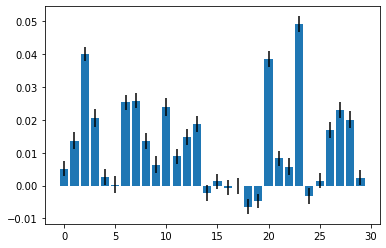

In [48]:
print(svs[2])
print(sv[0])
xvalues = np.arange(30)
plt.bar(xvalues,np.mean(svs,axis=0),yerr=np.std(svs,axis=0))

[0.00223307 0.0023642  0.00273147 0.00243632 0.00204685 0.00204992
 0.00250926 0.00267471 0.00233227 0.00253236 0.00214354 0.00223009
 0.00272757 0.00263734 0.00258261 0.00215128 0.00223034 0.0025647
 0.0023804  0.00247791 0.0026932  0.00245657 0.00223483 0.00258415
 0.00237992 0.00266519 0.00236038 0.00244965 0.00220022 0.00218889]
0.0024083071829197117


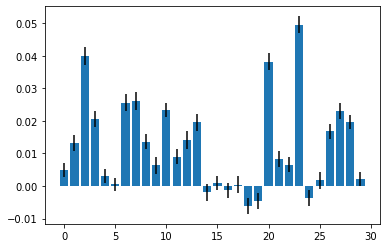

In [51]:
xvalues = np.arange(30)
plt.bar(xvalues,np.mean(svs2,axis=0),yerr=np.std(svs2,axis=0))
print(np.std(svs2,axis=0))
print(np.mean(np.std(svs2,axis=0)))

In [52]:
# inspect the kernel weights and randomly selected samples 
print(explainer.kernelWeights[59])
print(explainer.maskMatrix[59, :])
print(explainer.kernelWeights[60])
print(explainer.maskMatrix[60, :])
print(explainer.kernelWeights[61])
print(explainer.maskMatrix[61, :])
print(0.7388/2048)
print("this means that this sample was probably only selected once, but there are samples that were selected multiple times")


0.004352066129767854
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0.]
0.00034270687950553293
[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0.]
0.00034270687950553293
[1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 1.]
0.0003607421875
this means that this sample was probably only selected once, but there are samples that were selected multiple times


In [ ]:
### check the number of unique sets in maskMatrix 
p = explainer.maskMatrix
print(np.shape(p))
unique_rows = np.unique(p,axis=1)
w = explainer.kernelWeights[60:]
print(np.unique(w))
from collections import Counter 
print(Counter(w))

In [ ]:
def shap_kernel(z,p):
    return 2*(p-1)/(z*(p-z))

# for 10 clients: 
M = 4 
weights = [shap_kernel(xs,M) for xs in range(1,int(np.ceil(M/2))+1)]
weights = weights/np.sum(weights)
print(weights)
plt.plot(weights)

print("auto sets: ",2*M + 2**11)
auto_sets = 2*M + 2**11
print("total sets: ",2**M-2)
n_samples_left= 2**M-2
if auto_sets < n_samples_left: 
    n_samples_left = auto_sets 
print("n_samples_left: ",n_samples_left)
print(np.sum(weights))
remaining_weight_vector = weights
for i in range(1,int(np.ceil(M/2))+1):
    n_subsets = binom(M,i)
    print(n_subsets)
    print(n_samples_left)
    #remaining_weight_vector = weights[i-1]
    n_samples_left = n_samples_left - n_subsets 
    
    if (n_samples_left * remaining_weight_vector[i-1])/n_subsets > 1: 
        print('yes')
    else: 
        print((n_samples_left * remaining_weight_vector[i-1])/n_subsets)
        print('no')
        
    if remaining_weight_vector[i - 1] < 1.0:
        remaining_weight_vector /= (1 - remaining_weight_vector[i - 1])
    
    
    


In [ ]:
plt.plot(explainer.weight_vector)
print(np.sum(explainer.weight_vector))

In [ ]:
blub = explainer.explain()

In [ ]:
def explain(self, incoming_instance, **kwargs):
        # convert incoming input to a standardized iml object
        instance = convert_to_instance(incoming_instance)
        match_instance_to_data(instance, self.data)

        # find the feature groups we will test. If a feature does not change from its
        # current value then we know it doesn't impact the model
        self.varyingInds = self.varying_groups(instance.x)
        if self.data.groups is None:
            self.varyingFeatureGroups = np.array([i for i in self.varyingInds])
            self.M = self.varyingFeatureGroups.shape[0]
        else:
            self.varyingFeatureGroups = [self.data.groups[i] for i in self.varyingInds]
            self.M = len(self.varyingFeatureGroups)
            groups = self.data.groups
            # convert to numpy array as it is much faster if not jagged array (all groups of same length)
            if self.varyingFeatureGroups and all(len(groups[i]) == len(groups[0]) for i in self.varyingInds):
                self.varyingFeatureGroups = np.array(self.varyingFeatureGroups)
                # further performance optimization in case each group has a single value
                if self.varyingFeatureGroups.shape[1] == 1:
                    self.varyingFeatureGroups = self.varyingFeatureGroups.flatten()

        # find f(x)
        if self.keep_index:
            model_out = self.model.f(instance.convert_to_df())
        else:
            model_out = self.model.f(instance.x)
        if isinstance(model_out, (pd.DataFrame, pd.Series)):
            model_out = model_out.values
        self.fx = model_out[0]

        if not self.vector_out:
            self.fx = np.array([self.fx])

        # if no features vary then no feature has an effect
        if self.M == 0:
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))

        # if only one feature varies then it has all the effect
        elif self.M == 1:
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))
            diff = self.link.f(self.fx) - self.link.f(self.fnull)
            for d in range(self.D):
                phi[self.varyingInds[0],d] = diff[d]

        # if more than one feature varies then we have to do real work
        else:
            self.l1_reg = kwargs.get("l1_reg", "auto")

            # pick a reasonable number of samples if the user didn't specify how many they wanted
            self.nsamples = kwargs.get("nsamples", "auto")
            if self.nsamples == "auto":
                self.nsamples = 2 * self.M + 2**11

            # if we have enough samples to enumerate all subsets then ignore the unneeded samples
            self.max_samples = 2 ** 30
            if self.M <= 30:
                self.max_samples = 2 ** self.M - 2
                if self.nsamples > self.max_samples:
                    self.nsamples = self.max_samples
                    
            breakpoint()

            # reserve space for some of our computations
            self.allocate()

            # weight the different subset sizes
            num_subset_sizes = np.int(np.ceil((self.M - 1) / 2.0))
            num_paired_subset_sizes = np.int(np.floor((self.M - 1) / 2.0))
            weight_vector = np.array([(self.M - 1.0) / (i * (self.M - i)) for i in range(1, num_subset_sizes + 1)])
            weight_vector[:num_paired_subset_sizes] *= 2
            weight_vector /= np.sum(weight_vector)
            log.debug("weight_vector = {0}".format(weight_vector))
            log.debug("num_subset_sizes = {0}".format(num_subset_sizes))
            log.debug("num_paired_subset_sizes = {0}".format(num_paired_subset_sizes))
            log.debug("M = {0}".format(self.M))

            # fill out all the subset sizes we can completely enumerate
            # given nsamples*remaining_weight_vector[subset_size]
            num_full_subsets = 0
            num_samples_left = self.nsamples
            group_inds = np.arange(self.M, dtype='int64')
            mask = np.zeros(self.M)
            remaining_weight_vector = copy.copy(weight_vector)
            for subset_size in range(1, num_subset_sizes + 1):

                # determine how many subsets (and their complements) are of the current size
                nsubsets = binom(self.M, subset_size)
                if subset_size <= num_paired_subset_sizes: nsubsets *= 2
                log.debug("subset_size = {0}".format(subset_size))
                log.debug("nsubsets = {0}".format(nsubsets))
                log.debug("self.nsamples*weight_vector[subset_size-1] = {0}".format(
                    num_samples_left * remaining_weight_vector[subset_size - 1]))
                log.debug("self.nsamples*weight_vector[subset_size-1]/nsubsets = {0}".format(
                    num_samples_left * remaining_weight_vector[subset_size - 1] / nsubsets))

                # see if we have enough samples to enumerate all subsets of this size
                if num_samples_left * remaining_weight_vector[subset_size - 1] / nsubsets >= 1.0 - 1e-8:
                    num_full_subsets += 1
                    num_samples_left -= nsubsets

                    # rescale what's left of the remaining weight vector to sum to 1
                    if remaining_weight_vector[subset_size - 1] < 1.0:
                        remaining_weight_vector /= (1 - remaining_weight_vector[subset_size - 1])

                    # add all the samples of the current subset size
                    w = weight_vector[subset_size - 1] / binom(self.M, subset_size)
                    if subset_size <= num_paired_subset_sizes: w /= 2.0
                    for inds in itertools.combinations(group_inds, subset_size):
                        mask[:] = 0.0
                        mask[np.array(inds, dtype='int64')] = 1.0
                        self.addsample(instance.x, mask, w)
                        if subset_size <= num_paired_subset_sizes:
                            mask[:] = np.abs(mask - 1)
                            self.addsample(instance.x, mask, w)
                else:
                    break
            log.info("num_full_subsets = {0}".format(num_full_subsets))

            # add random samples from what is left of the subset space
            nfixed_samples = self.nsamplesAdded
            samples_left = self.nsamples - self.nsamplesAdded
            log.debug("samples_left = {0}".format(samples_left))
            if num_full_subsets != num_subset_sizes:
                remaining_weight_vector = copy.copy(weight_vector)
                remaining_weight_vector[:num_paired_subset_sizes] /= 2 # because we draw two samples each below
                remaining_weight_vector = remaining_weight_vector[num_full_subsets:]
                remaining_weight_vector /= np.sum(remaining_weight_vector)
                log.info("remaining_weight_vector = {0}".format(remaining_weight_vector))
                log.info("num_paired_subset_sizes = {0}".format(num_paired_subset_sizes))
                ind_set = np.random.choice(len(remaining_weight_vector), 4 * samples_left, p=remaining_weight_vector)
                ind_set_pos = 0
                used_masks = {}
                while samples_left > 0 and ind_set_pos < len(ind_set):
                    mask.fill(0.0)
                    ind = ind_set[ind_set_pos] # we call np.random.choice once to save time and then just read it here
                    ind_set_pos += 1
                    subset_size = ind + num_full_subsets + 1
                    mask[np.random.permutation(self.M)[:subset_size]] = 1.0

                    # only add the sample if we have not seen it before, otherwise just
                    # increment a previous sample's weight
                    mask_tuple = tuple(mask)
                    new_sample = False
                    if mask_tuple not in used_masks:
                        new_sample = True
                        used_masks[mask_tuple] = self.nsamplesAdded
                        samples_left -= 1
                        self.addsample(instance.x, mask, 1.0)
                    else:
                        self.kernelWeights[used_masks[mask_tuple]] += 1.0

                    # add the compliment sample
                    if samples_left > 0 and subset_size <= num_paired_subset_sizes:
                        mask[:] = np.abs(mask - 1)

                        # only add the sample if we have not seen it before, otherwise just
                        # increment a previous sample's weight
                        if new_sample:
                            samples_left -= 1
                            self.addsample(instance.x, mask, 1.0)
                        else:
                            # we know the compliment sample is the next one after the original sample, so + 1
                            self.kernelWeights[used_masks[mask_tuple] + 1] += 1.0

                # normalize the kernel weights for the random samples to equal the weight left after
                # the fixed enumerated samples have been already counted
                weight_left = np.sum(weight_vector[num_full_subsets:])
                log.info("weight_left = {0}".format(weight_left))
                self.kernelWeights[nfixed_samples:] *= weight_left / self.kernelWeights[nfixed_samples:].sum()

            # execute the model on the synthetic samples we have created
            self.run()

            # solve then expand the feature importance (Shapley value) vector to contain the non-varying features
            phi = np.zeros((self.data.groups_size, self.D))
            phi_var = np.zeros((self.data.groups_size, self.D))
            for d in range(self.D):
                vphi, vphi_var = self.solve(self.nsamples / self.max_samples, d)
                phi[self.varyingInds, d] = vphi
                phi_var[self.varyingInds, d] = vphi_var

        if not self.vector_out:
            phi = np.squeeze(phi, axis=1)
            phi_var = np.squeeze(phi_var, axis=1)

        return phi

    
    def not_equal(i, j):
        number_types = (int, float, np.number)
        if isinstance(i, number_types) and isinstance(j, number_types):
            return 0 if np.isclose(i, j, equal_nan=True) else 1
        else:
            return 0 if i == j else 1

    def varying_groups(self, x):
        if not sp.sparse.issparse(x):
            varying = np.zeros(self.data.groups_size)
            for i in range(0, self.data.groups_size):
                inds = self.data.groups[i]
                x_group = x[0, inds]
                if sp.sparse.issparse(x_group):
                    if all(j not in x.nonzero()[1] for j in inds):
                        varying[i] = False
                        continue
                    x_group = x_group.todense()
                num_mismatches = np.sum(np.frompyfunc(self.not_equal, 2, 1)(x_group, self.data.data[:, inds]))
                varying[i] = num_mismatches > 0
            varying_indices = np.nonzero(varying)[0]
            return varying_indices
        else:
            varying_indices = []
            # go over all nonzero columns in background and evaluation data
            # if both background and evaluation are zero, the column does not vary
            varying_indices = np.unique(np.union1d(self.data.data.nonzero()[1], x.nonzero()[1]))
            remove_unvarying_indices = []
            for i in range(0, len(varying_indices)):
                varying_index = varying_indices[i]
                # now verify the nonzero values do vary
                data_rows = self.data.data[:, [varying_index]]
                nonzero_rows = data_rows.nonzero()[0]

                if nonzero_rows.size > 0:
                    background_data_rows = data_rows[nonzero_rows]
                    if sp.sparse.issparse(background_data_rows):
                        background_data_rows = background_data_rows.toarray()
                    num_mismatches = np.sum(np.abs(background_data_rows - x[0, varying_index]) > 1e-7)
                    # Note: If feature column non-zero but some background zero, can't remove index
                    if num_mismatches == 0 and not \
                        (np.abs(x[0, [varying_index]][0, 0]) > 1e-7 and len(nonzero_rows) < data_rows.shape[0]):
                        remove_unvarying_indices.append(i)
            mask = np.ones(len(varying_indices), dtype=bool)
            mask[remove_unvarying_indices] = False
            varying_indices = varying_indices[mask]
            return varying_indices

    def allocate(self):
        if sp.sparse.issparse(self.data.data):
            # We tile the sparse matrix in csr format but convert it to lil
            # for performance when adding samples
            shape = self.data.data.shape
            nnz = self.data.data.nnz
            data_rows, data_cols = shape
            rows = data_rows * self.nsamples
            shape = rows, data_cols
            if nnz == 0:
                self.synth_data = sp.sparse.csr_matrix(shape, dtype=self.data.data.dtype).tolil()
            else:
                data = self.data.data.data
                indices = self.data.data.indices
                indptr = self.data.data.indptr
                last_indptr_idx = indptr[len(indptr) - 1]
                indptr_wo_last = indptr[:-1]
                new_indptrs = []
                for i in range(0, self.nsamples - 1):
                    new_indptrs.append(indptr_wo_last + (i * last_indptr_idx))
                new_indptrs.append(indptr + ((self.nsamples - 1) * last_indptr_idx))
                new_indptr = np.concatenate(new_indptrs)
                new_data = np.tile(data, self.nsamples)
                new_indices = np.tile(indices, self.nsamples)
                self.synth_data = sp.sparse.csr_matrix((new_data, new_indices, new_indptr), shape=shape).tolil()
        else:
            self.synth_data = np.tile(self.data.data, (self.nsamples, 1))

        self.maskMatrix = np.zeros((self.nsamples, self.M))
        self.kernelWeights = np.zeros(self.nsamples)
        self.y = np.zeros((self.nsamples * self.N, self.D))
        self.ey = np.zeros((self.nsamples, self.D))
        self.lastMask = np.zeros(self.nsamples)
        self.nsamplesAdded = 0
        self.nsamplesRun = 0
        if self.keep_index:
            self.synth_data_index = np.tile(self.data.index_value, self.nsamples)

    def addsample(self, x, m, w):
        offset = self.nsamplesAdded * self.N
        if isinstance(self.varyingFeatureGroups, (list,)):
            for j in range(self.M):
                for k in self.varyingFeatureGroups[j]:
                    if m[j] == 1.0:
                        self.synth_data[offset:offset+self.N, k] = x[0, k]
        else:
            # for non-jagged numpy array we can significantly boost performance
            mask = m == 1.0
            groups = self.varyingFeatureGroups[mask]
            if len(groups.shape) == 2:
                for group in groups:
                    self.synth_data[offset:offset+self.N, group] = x[0, group]
            else:
                # further performance optimization in case each group has a single feature
                evaluation_data = x[0, groups]
                # In edge case where background is all dense but evaluation data
                # is all sparse, make evaluation data dense
                if sp.sparse.issparse(x) and not sp.sparse.issparse(self.synth_data):
                    evaluation_data = evaluation_data.toarray()
                self.synth_data[offset:offset+self.N, groups] = evaluation_data
        self.maskMatrix[self.nsamplesAdded, :] = m
        self.kernelWeights[self.nsamplesAdded] = w
        self.nsamplesAdded += 1

    def run(self):
        num_to_run = self.nsamplesAdded * self.N - self.nsamplesRun * self.N
        data = self.synth_data[self.nsamplesRun*self.N:self.nsamplesAdded*self.N,:]
        if self.keep_index:
            index = self.synth_data_index[self.nsamplesRun*self.N:self.nsamplesAdded*self.N]
            index = pd.DataFrame(index, columns=[self.data.index_name])
            data = pd.DataFrame(data, columns=self.data.group_names)
            data = pd.concat([index, data], axis=1).set_index(self.data.index_name)
            if self.keep_index_ordered:
                data = data.sort_index()
        modelOut = self.model.f(data)
        if isinstance(modelOut, (pd.DataFrame, pd.Series)):
            modelOut = modelOut.values
        self.y[self.nsamplesRun * self.N:self.nsamplesAdded * self.N, :] = np.reshape(modelOut, (num_to_run, self.D))

        # find the expected value of each output
        for i in range(self.nsamplesRun, self.nsamplesAdded):
            eyVal = np.zeros(self.D)
            for j in range(0, self.N):
                eyVal += self.y[i * self.N + j, :] * self.data.weights[j]

            self.ey[i, :] = eyVal
            self.nsamplesRun += 1

    def solve(self, fraction_evaluated, dim):
        eyAdj = self.linkfv(self.ey[:, dim]) - self.link.f(self.fnull[dim])
        s = np.sum(self.maskMatrix, 1)

        # do feature selection if we have not well enumerated the space
        nonzero_inds = np.arange(self.M)
        log.debug("fraction_evaluated = {0}".format(fraction_evaluated))
        # if self.l1_reg == "auto":
        #     warnings.warn(
        #         "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
        #         "conditional use of AIC to simply \"num_features(10)\"!"
        #     )
        if (self.l1_reg not in ["auto", False, 0]) or (fraction_evaluated < 0.2 and self.l1_reg == "auto"):
            w_aug = np.hstack((self.kernelWeights * (self.M - s), self.kernelWeights * s))
            log.info("np.sum(w_aug) = {0}".format(np.sum(w_aug)))
            log.info("np.sum(self.kernelWeights) = {0}".format(np.sum(self.kernelWeights)))
            w_sqrt_aug = np.sqrt(w_aug)
            eyAdj_aug = np.hstack((eyAdj, eyAdj - (self.link.f(self.fx[dim]) - self.link.f(self.fnull[dim]))))
            eyAdj_aug *= w_sqrt_aug
            mask_aug = np.transpose(w_sqrt_aug * np.transpose(np.vstack((self.maskMatrix, self.maskMatrix - 1))))
            #var_norms = np.array([np.linalg.norm(mask_aug[:, i]) for i in range(mask_aug.shape[1])])

            # select a fixed number of top features
            if isinstance(self.l1_reg, str) and self.l1_reg.startswith("num_features("):
                r = int(self.l1_reg[len("num_features("):-1])
                nonzero_inds = lars_path(mask_aug, eyAdj_aug, max_iter=r)[1]

            # use an adaptive regularization method
            elif self.l1_reg == "auto" or self.l1_reg == "bic" or self.l1_reg == "aic":
                c = "aic" if self.l1_reg == "auto" else self.l1_reg
                nonzero_inds = np.nonzero(LassoLarsIC(criterion=c).fit(mask_aug, eyAdj_aug).coef_)[0]

            # use a fixed regularization coeffcient
            else:
                nonzero_inds = np.nonzero(Lasso(alpha=self.l1_reg).fit(mask_aug, eyAdj_aug).coef_)[0]

        if len(nonzero_inds) == 0:
            return np.zeros(self.M), np.ones(self.M)

        # eliminate one variable with the constraint that all features sum to the output
        eyAdj2 = eyAdj - self.maskMatrix[:, nonzero_inds[-1]] * (
                    self.link.f(self.fx[dim]) - self.link.f(self.fnull[dim]))
        etmp = np.transpose(np.transpose(self.maskMatrix[:, nonzero_inds[:-1]]) - self.maskMatrix[:, nonzero_inds[-1]])
        log.debug("etmp[:4,:] {0}".format(etmp[:4, :]))

        # solve a weighted least squares equation to estimate phi
        tmp = np.transpose(np.transpose(etmp) * np.transpose(self.kernelWeights))
        etmp_dot = np.dot(np.transpose(tmp), etmp)
        try:
            tmp2 = np.linalg.inv(etmp_dot)
        except np.linalg.LinAlgError:
            tmp2 = np.linalg.pinv(etmp_dot)
            warnings.warn(
                "Linear regression equation is singular, Moore-Penrose pseudoinverse is used instead of the regular inverse.\n"
                "To use regular inverse do one of the following:\n"
                "1) turn up the number of samples,\n"
                "2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,\n"
                "3) group features together to reduce the number of inputs that need to be explained."
            )
        w = np.dot(tmp2, np.dot(np.transpose(tmp), eyAdj2))
        log.debug("np.sum(w) = {0}".format(np.sum(w)))
        log.debug("self.link(self.fx) - self.link(self.fnull) = {0}".format(
            self.link.f(self.fx[dim]) - self.link.f(self.fnull[dim])))
        log.debug("self.fx = {0}".format(self.fx[dim]))
        log.debug("self.link(self.fx) = {0}".format(self.link.f(self.fx[dim])))
        log.debug("self.fnull = {0}".format(self.fnull[dim]))
        log.debug("self.link(self.fnull) = {0}".format(self.link.f(self.fnull[dim])))
        phi = np.zeros(self.M)
        phi[nonzero_inds[:-1]] = w
        phi[nonzero_inds[-1]] = (self.link.f(self.fx[dim]) - self.link.f(self.fnull[dim])) - sum(w)
        log.info("phi = {0}".format(phi))

        # clean up any rounding errors
        for i in range(self.M):
            if np.abs(phi[i]) < 1e-10:
                phi[i] = 0

        return phi, np.ones(len(phi))

In [ ]:
from itertools import  product

def create_mask_arrays(k):
  mask = np.array(list(product(range(2), repeat=k)))
  mask = mask[~np.all(mask == 0, axis=1)]
  mask = mask[~np.all(mask == 1, axis=1)]
  return mask

mask = create_mask_arrays(10) #np.shape(x_train)[1])
print(mask)

from scipy.special import comb


def calculate_weight(mask_row):
  M = no_of_features = len(mask_row)
  z = no_of_masked_feature = np.sum(mask_row)
  
  weight = (M-1) /  (  comb(M,z) * z * (M-z)   )
  return weight

weights  = np.apply_along_axis(calculate_weight, 1, mask)
weights



In [ ]:
print(np.shape(weights))

0.03333333333333333
[0.03333333333333333, 0.0011904761904761906, 8.818342151675486e-05, 1.0175010175010176e-05, 1.628001628001628e-06, 3.391670058336725e-07, 8.847834934791456e-08, 2.8152202065245543e-08, 1.0724648405807826e-08, 4.826091782613522e-09, 2.5400483066386956e-09, 1.5522517429458695e-09, 1.0957071126676727e-09, 8.90262029042484e-10, 8.309112271063184e-10, 8.90262029042484e-10, 1.0957071126676727e-09, 1.5522517429458695e-09, 2.5400483066386956e-09, 4.826091782613522e-09, 1.0724648405807826e-08, 2.8152202065245543e-08, 8.847834934791456e-08, 3.391670058336725e-07, 1.628001628001628e-06, 1.0175010175010176e-05, 8.818342151675486e-05, 0.0011904761904761906, 0.03333333333333333]


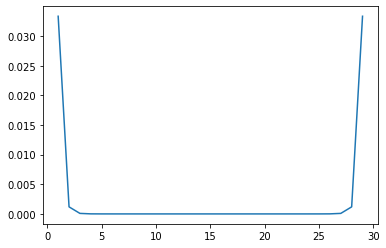

In [17]:
import matplotlib.pyplot as plt 
from scipy.special import binom 

def shap_kernel(z,p):
    return (p-1)/(binom(p,z)*(z*(p-z)))
    #return (p-1)/(z*(p-z))
    
n_clients = 30
xx = list(range(1,n_clients))
scaling_factor = shap_kernel(1,n_clients)
print(scaling_factor)
print([shap_kernel(z,n_clients) for z in xx])
plt.plot(xx, [shap_kernel(z,n_clients) for z in xx])

In [ ]:
transformed = scaler.fit_transform(x_train)

mean_array = torch.mean(torch.from_numpy(transformed).float(),0)
print(mean_array)

mean_prediction = model(Variable(mean_array))
print(mean_prediction)

In [ ]:
from itertools import  product

def create_mask_arrays(k):
  mask = np.array(list(product(range(2), repeat=k)))
  mask = mask[~np.all(mask == 0, axis=1)]
  mask = mask[~np.all(mask == 1, axis=1)]
  return mask

mask = create_mask_arrays(2) #np.shape(x_train)[1])
print(mask)

In [ ]:
print(np.shape(x_train)[1])

In [ ]:
from scipy.special import comb


def calculate_weight(mask_row):
  M = no_of_features = len(mask_row)
  z = no_of_masked_feature = np.sum(mask_row)
  
  weight = (M-1) /  (  comb(M,z) * z * (M-z)   )
  return weight


In [ ]:
mean_ref_array = x.mean()
print(mean_ref_array )
## random training subset, an instance compare

In [ ]:
instance_to_explain = test_set[0,:] #.detach().cpu().numpy() #x_test[0]
print(instance_to_explain)
     
y_val_pred = model(Variable(instance_to_explain))
print(y_val_pred[0])

transformed = scaler.fit_transform(x_train)

mean_array = torch.mean(torch.from_numpy(transformed).float(),0)
print(mean_array)

mean_prediction = model(Variable(mean_array))
print(mean_prediction)

In [ ]:
S_with_zero = mask*instance_to_explain.detach().cpu().numpy()
print(S_with_zero)
print("-000-")
print(instance_to_explain)

In [ ]:
S_full = (S_with_zero == 0)*mean_array.detach().cpu().numpy() + S_with_zero
print(S_full)
     

In [ ]:
calculate_weight([0,1,0,0])

In [ ]:
weights  = np.apply_along_axis(calculate_weight, 1, mask)
weights

In [ ]:
print(np.shape(S_full))
print(np.shape(x_train))

In [ ]:
print(S_full[0,:])
print(x_train[0,:])

In [ ]:
X = mask 
y = model(Variable(torch.from_numpy(S_with_zero).float()))
y = y.detach().cpu().numpy()

B0 = mean_prediction
B0 = B0.detach().cpu().numpy()
W = np.diag(weights)
print(y)
y = y - B0
print(y)

B = np.dot(np.linalg.inv(np.dot(np.dot(X.transpose(),W),X)), np.dot(np.dot(X.transpose(),W),y))

print("Our Shapley values are:", B)